## Data Sources
* McDonald's menu: https://www.kaggle.com/mcdonalds/nutrition-facts/
* Subway menu: Downloaded PDF from http://www.subway.com/~/media/usa/documents/nutrition/us_nutrition_values.pdf and converted to csv

Both data sources included the same nutritional information on an item-by-item basis. Only needed cleanup was ensuring nutrition column names were exact matches before merging the two datasets for later analysis

## Research Questions
* Develop methodology to rank the relative health of each item on each menu on a category by category basis
* Which items from McDonald's and Subway are similar to each other?
* Is Subway healthier than McDonald's overall?

## Importing Libraries and Data

In [209]:
import numpy as np
import scipy as sp
import os
import scipy.spatial.distance as spd
import scipy.cluster.hierarchy as sph
import sklearn as sk
import sklearn.metrics as skm
import sklearn.cluster as skc
import sklearn.decomposition as skd
import sklearn.mixture as skmix
from scipy import stats
import statsmodels.formula.api as smf
import statsmodels.api as sm
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set(style='white', color_codes=True, font_scale=1.3)
import re
exec(open('useful.py').read())

# make the Pandas tables a little more readable
from IPython.core.display import HTML
css = open('style-table.css').read() + open('style-notebook.css').read()
HTML('<style>{}</style>'.format(css))

In [210]:
mcd_menu = pd.read_csv("menu.csv", index_col=1)
subway_menu = pd.read_csv("subway_menu.csv", index_col=0)

## Cleaning Datasets

In [211]:
mcd_menu.head()

Category    Serving Size  Calories  \
Item                                                                    
Egg McMuffin                      Breakfast  4.8 oz (136 g)       300   
Egg White Delight                 Breakfast  4.8 oz (135 g)       250   
Sausage McMuffin                  Breakfast  3.9 oz (111 g)       370   
Sausage McMuffin with Egg         Breakfast  5.7 oz (161 g)       450   
Sausage McMuffin with Egg Whites  Breakfast  5.7 oz (161 g)       400   

                                  Calories from Fat  Total Fat  \
Item                                                             
Egg McMuffin                                    120       13.0   
Egg White Delight                                70        8.0   
Sausage McMuffin                                200       23.0   
Sausage McMuffin with Egg                       250       28.0   
Sausage McMuffin with Egg Whites                210       23.0   

                                  Total Fat (% Daily Value)  Saturated Fat  \
Item                                                                         
Egg McMuffin                                             20            5.0   
Egg White Delight                                        12            3.0   
Sausage McMuffin                                         35            8.0   
Sausage McMuffin with Egg                                43           10.0   
Sausage McMuffin with Egg Whites                         35            8.0   

                                  Saturated Fat (% Daily Value)  Trans Fat  \
Item                                                                         
Egg McMuffin                                                 25        0.0   
Egg White Delight                                            15        0.0   
Sausage McMuffin                                             42        0.0   
Sausage McMuffin with Egg                                    52        0.0   
Sausage McMuffin with Egg Whites                             42        0.0   

                                  Cholesterol          ...           \
Item                                                   ...            
Egg McMuffin                              260          ...            
Egg White Delight                          25          ...            
Sausage McMuffin                           45          ...            
Sausage McMuffin with Egg                 285          ...            
Sausage McMuffin with Egg Whites           50          ...            

                                  Carbohydrates  \
Item                                              
Egg McMuffin                                 31   
Egg White Delight                            30   
Sausage McMuffin                             29   
Sausage McMuffin with Egg                    30   
Sausage McMuffin with Egg Whites             30   

                                  Carbohydrates (% Daily Value)  \
Item                                                              
Egg McMuffin                                                 10   
Egg White Delight                                            10   
Sausage McMuffin                                             10   
Sausage McMuffin with Egg                                    10   
Sausage McMuffin with Egg Whites                             10   

                                  Dietary Fiber  \
Item                                              
Egg McMuffin                                  4   
Egg White Delight                             4   
Sausage McMuffin                              4   
Sausage McMuffin with Egg                     4   
Sausage McMuffin with Egg Whites              4   

                                  Dietary Fiber (% Daily Value)  Sugars  \
Item                                                                      
Egg McMuffin                                                 17       3   
Egg White Delight                                        

In [212]:
subway_menu.head()

Category  Serving Size (g) Calories  \
Item                                                               
6" Black Forest Ham          Sandwich               219      290   
6" Oven Roasted Chicken      Sandwich               233      320   
6" Roast Beef                Sandwich               233      320   
6" Rotisserie-Style Chicken  Sandwich               247      350   
6" Subway Club®              Sandwich               240      310   

                             Cal. From Fat  Total Fat (g)  Sat. Fat (g)  \
Item                                                                      
6" Black Forest Ham                     40            4.5           1.0   
6" Oven Roasted Chicken                 45            5.0           1.5   
6" Roast Beef                           40            5.0           1.5   
6" Rotisserie-Style Chicken             55            6.0           1.5   
6" Subway Club®                         40            4.5           1.5   

                             Trans Fat (g)*  Chol. (mg)  Sodium (mg)  \
Item                                                                   
6" Black Forest Ham                     0.0          25          800   
6" Oven Roasted Chicken                 0.0          45          610   
6" Roast Beef                           0.0          45          660   
6" Rotisserie-Style Chicken             0.0          55          540   
6" Subway Club®                         0.0          40          840   

                            Carbohydrate(g) Dietary Fiber (g)  Sugars (g)  \
Item                                                                        
6" Black Forest Ham                      46                 5           8   
6" Oven Roasted Chicken                  46                 5           8   
6" Roast Beef                            45                 5           7   
6" Rotisserie-Style Chicken              45                 5           7   
6" Subway Club®                          46                 5           8   

                             Protein(g)  Vitamin A % DV  Vitamin C % DV  \
Item                                                                      
6" Black Forest Ham                  18               8              20   
6" Oven Roasted Chicken              23               8              30   
6" Roast Beef                        25               8              20   
6" Rotisserie-Style Chicken          29              10              20   
6" Subway Club®                      23               8              20   

                             Calcium % DV  Iron % DV  
Item                                                  
6" Black Forest Ham                    30         15  
6" Oven Roasted Chicken                30         15  
6" Roast Beef                          30         25  
6" Rotisserie-Style Chicken            30         20  
6" Subway Club®                        30         20

In [213]:
mcd_menu['Serving Size'] = mcd_menu['Serving Size'].astype(str).str.extract('([0-9]*[.])?[0-9]+').astype(float)
# this conversion worked for most entries, but failed on ones without a decimal

/Users/alexschwartz/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:1: FutureWarning: currently extract(expand=None) means expand=False (return Index/Series/DataFrame) but in a future version of pandas this will be changed to expand=True (return DataFrame)
  if __name__ == '__main__':


In [214]:
mcd_columns = mcd_menu.columns
subway_columns = subway_menu.columns

In [215]:
# checking data type of all colums
for column in mcd_columns:
    print(column, ":", mcd_menu[column].dtype)

Category : object
Serving Size : float64
Calories : int64
Calories from Fat : int64
Total Fat : float64
Total Fat (% Daily Value) : int64
Saturated Fat : float64
Saturated Fat (% Daily Value) : int64
Trans Fat : float64
Cholesterol : int64
Cholesterol (% Daily Value) : int64
Sodium : int64
Sodium (% Daily Value) : int64
Carbohydrates : int64
Carbohydrates (% Daily Value) : int64
Dietary Fiber : int64
Dietary Fiber (% Daily Value) : int64
Sugars : int64
Protein : int64
Vitamin A (% Daily Value) : int64
Vitamin C (% Daily Value) : int64
Calcium (% Daily Value) : int64
Iron (% Daily Value) : int64


In [216]:
for column in subway_columns:
    print(column, ":", subway_menu[column].dtype)

Category : object
Serving Size (g) : int64
Calories : object
Cal. From Fat : int64
Total Fat (g) : float64
Sat. Fat (g) : float64
Trans Fat (g)* : float64
Chol. (mg) : int64
Sodium (mg) : int64
Carbohydrate(g) : object
Dietary Fiber (g) : object
Sugars (g) : int64
Protein(g) : int64
Vitamin A % DV : int64
Vitamin C % DV : int64
Calcium % DV : int64
Iron % DV : int64


In [217]:
# converting object columns to floats
for column in mcd_columns[1:]:
    mcd_menu[column] = pd.to_numeric(mcd_menu[column], errors='coerce')

In [218]:
for column in subway_columns[1:]:
    subway_menu[column] = pd.to_numeric(subway_menu[column], errors='coerce')

In [219]:
# use of coerce option led to NaNs (mainly in the Serving Size column). Filling them in to avoid errors
mcd_menu = mcd_menu.fillna(0)

In [220]:
subway_menu = subway_menu.fillna(0)

In [221]:
# subway menu says to double all 6" sub nutritional data for footlongs. might look at this later
footlong_subs = subway_menu[subway_menu.Category == 'Sandwich'].ix[:,1:] * 2

In [222]:
# pulling this up for reference below
mcd_columns

Index(['Category', 'Serving Size', 'Calories', 'Calories from Fat',
       'Total Fat', 'Total Fat (% Daily Value)', 'Saturated Fat',
       'Saturated Fat (% Daily Value)', 'Trans Fat', 'Cholesterol',
       'Cholesterol (% Daily Value)', 'Sodium', 'Sodium (% Daily Value)',
       'Carbohydrates', 'Carbohydrates (% Daily Value)', 'Dietary Fiber',
       'Dietary Fiber (% Daily Value)', 'Sugars', 'Protein',
       'Vitamin A (% Daily Value)', 'Vitamin C (% Daily Value)',
       'Calcium (% Daily Value)', 'Iron (% Daily Value)'],
      dtype='object')

In [223]:
focus_columns = ['Category', 'Serving Size', 'Calories', 'Calories from Fat',
       'Total Fat','Cholesterol','Sodium','Carbohydrates', 'Sugars', 'Protein',]

In [224]:
subway_columns

Index(['Category', 'Serving Size (g)', 'Calories', 'Cal. From Fat',
       'Total Fat (g)', 'Sat. Fat (g)', 'Trans Fat (g)*', 'Chol. (mg)',
       'Sodium (mg)', 'Carbohydrate(g)', 'Dietary Fiber (g)', 'Sugars (g)',
       'Protein(g)', 'Vitamin A % DV', 'Vitamin C % DV', 'Calcium % DV',
       'Iron % DV'],
      dtype='object')

In [225]:
# slightly renaming subway columns to they 100% match mcd column names before appending into combined df
subway_menu.rename(columns={'Serving Size (g)': 'Serving Size', 'Cal. From Fat': 'Calories from Fat',
                           'Total Fat (g)': 'Total Fat', 'Sat. Fat (g)': 'Saturated Fat', 'Trans Fat (g)*': 'Trans Fat',
                            'Chol. (mg)': 'Cholesterol', 'Sodium (mg)': 'Sodium', 'Carbohydrate(g)': 'Carbohydrates',
                            'Dietary Fiber (g)': 'Dietary Fiber', 'Sugars (g)': 'Sugars', 'Protein(g)': 'Protein',
                            'Vitamin A % DV': 'Vitamin A (% Daily Value)', 'Vitamin C % DV' : 'Vitamin C (% Daily Value)',
                            'Calcium % DV': 'Calcium (% Daily Value)','Iron % DV': 'Iron (% Daily Value)'}, inplace=True)

In [226]:
subway_columns = subway_menu.columns

In [227]:
# adding restaurant column to keep track of which menu each item is from, and then appending into combined df
subway_menu['Restaurant'] = 'Subway'
mcd_menu['Restaurant'] = 'McDonalds'
combined_menu = mcd_menu.append(subway_menu)

In [228]:
mcd_menu.Category.unique()

array(['Breakfast', 'Beef & Pork', 'Chicken & Fish', 'Salads',
       'Snacks & Sides', 'Desserts', 'Beverages', 'Coffee & Tea',
       'Smoothies & Shakes'], dtype=object)

In [229]:
subway_menu.Category.unique()

array(['Sandwich', 'Salad', 'Dressing', 'Breakfast', 'Pizza', 'Bread',
       'Condiments', 'Vegetables', 'Cheese', 'Meat', 'Dessert', 'Soup'], dtype=object)

## Basic Descriptive Stats

### McDonald's

/Users/alexschwartz/anaconda/lib/python3.5/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


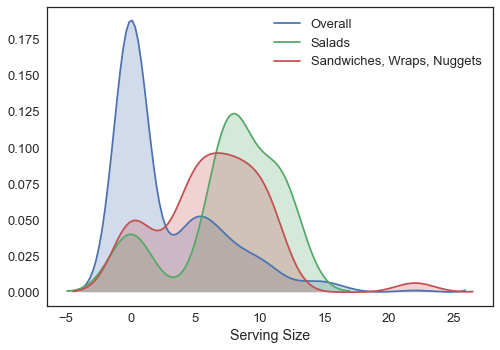

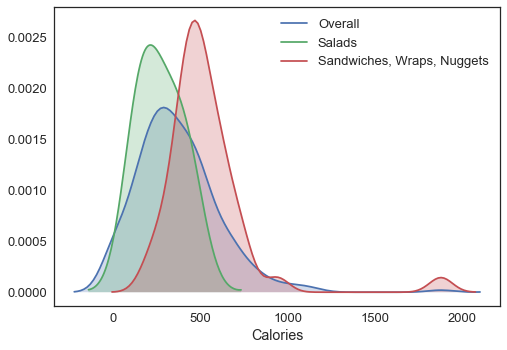

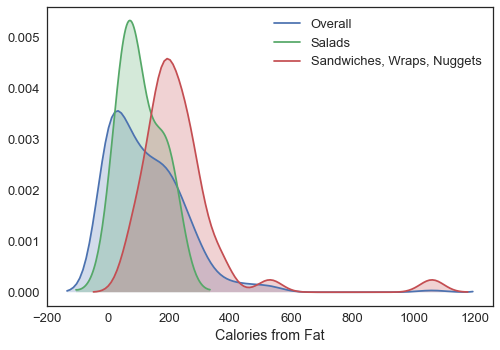

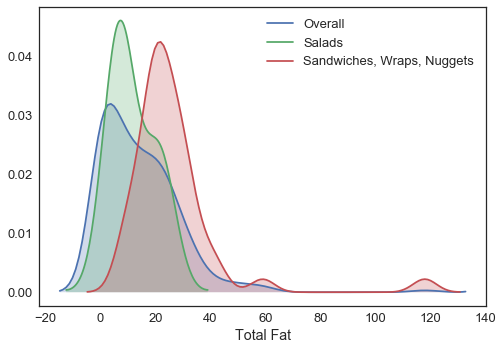

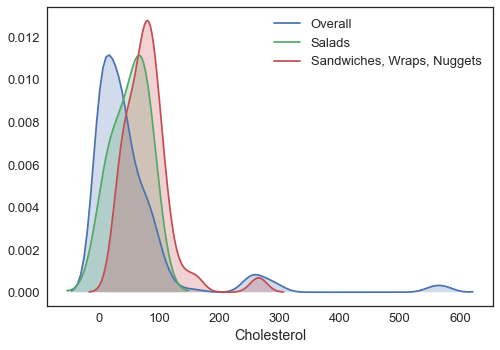

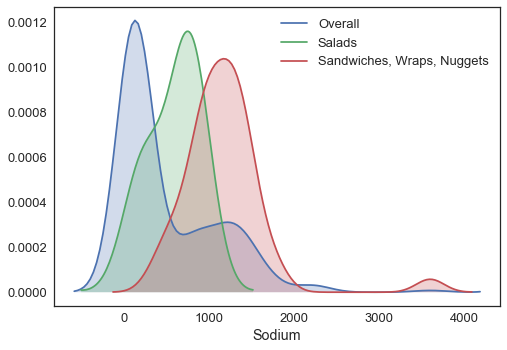

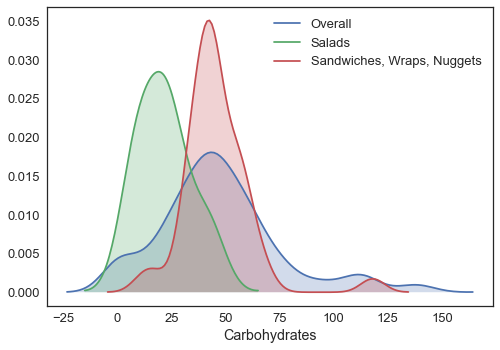

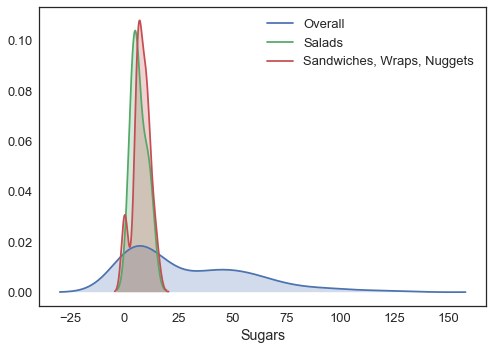

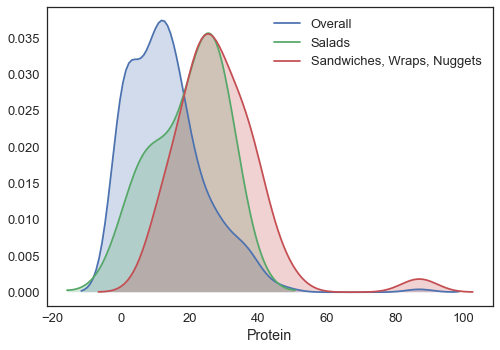

In [230]:
# investigating distribution of each nutrient for entire menu, salads, and other main entrees
for column in focus_columns[1:]:
    sns.distplot(mcd_menu[column], hist=False, kde_kws={"shade": True}, label = 'Overall')
    sns.distplot(mcd_menu[mcd_menu.Category == 'Salads'][column], hist=False, kde_kws={"shade": True}, label = 'Salads')
    sns.distplot(mcd_menu[(mcd_menu.Category == 'Beef & Pork') | (mcd_menu.Category == 'Chicken & Fish')][column], hist=False, kde_kws={"shade": True}, label = 'Sandwiches, Wraps, Nuggets')
    plt.figure()

Findings from above:
* Calories: 

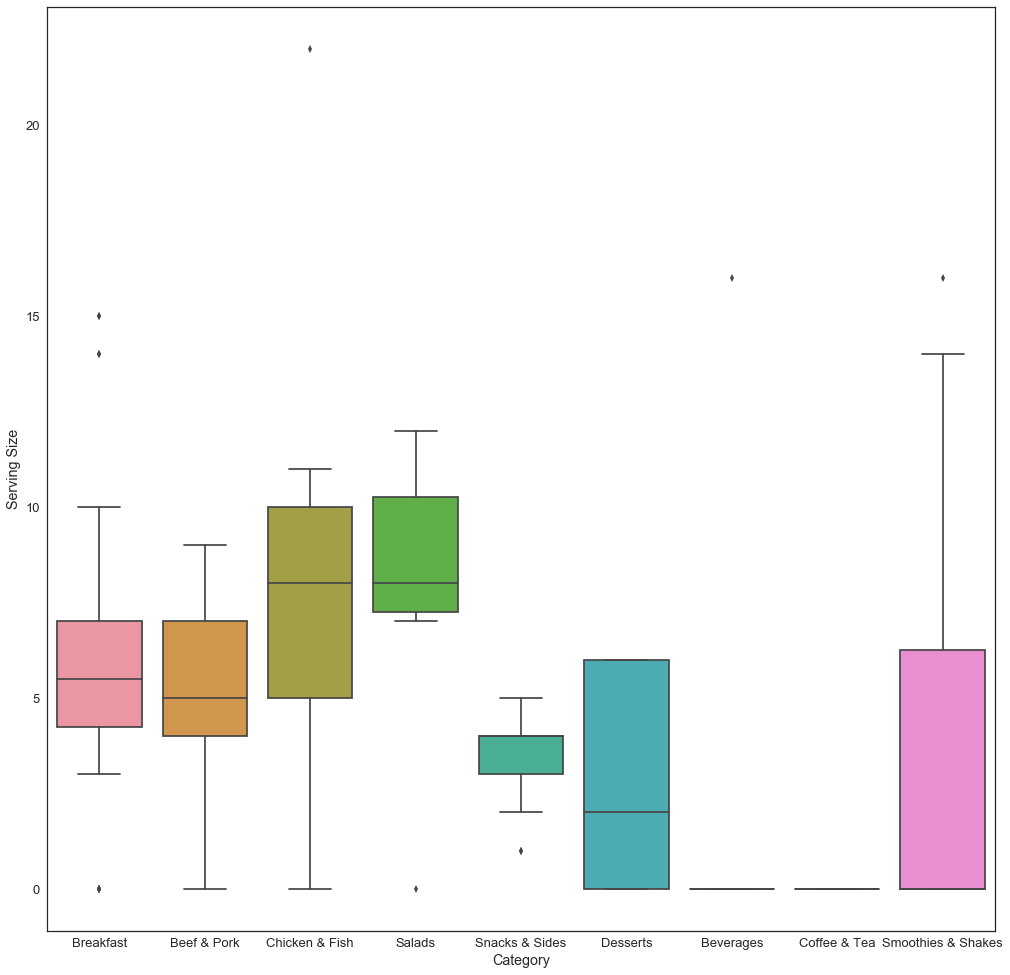

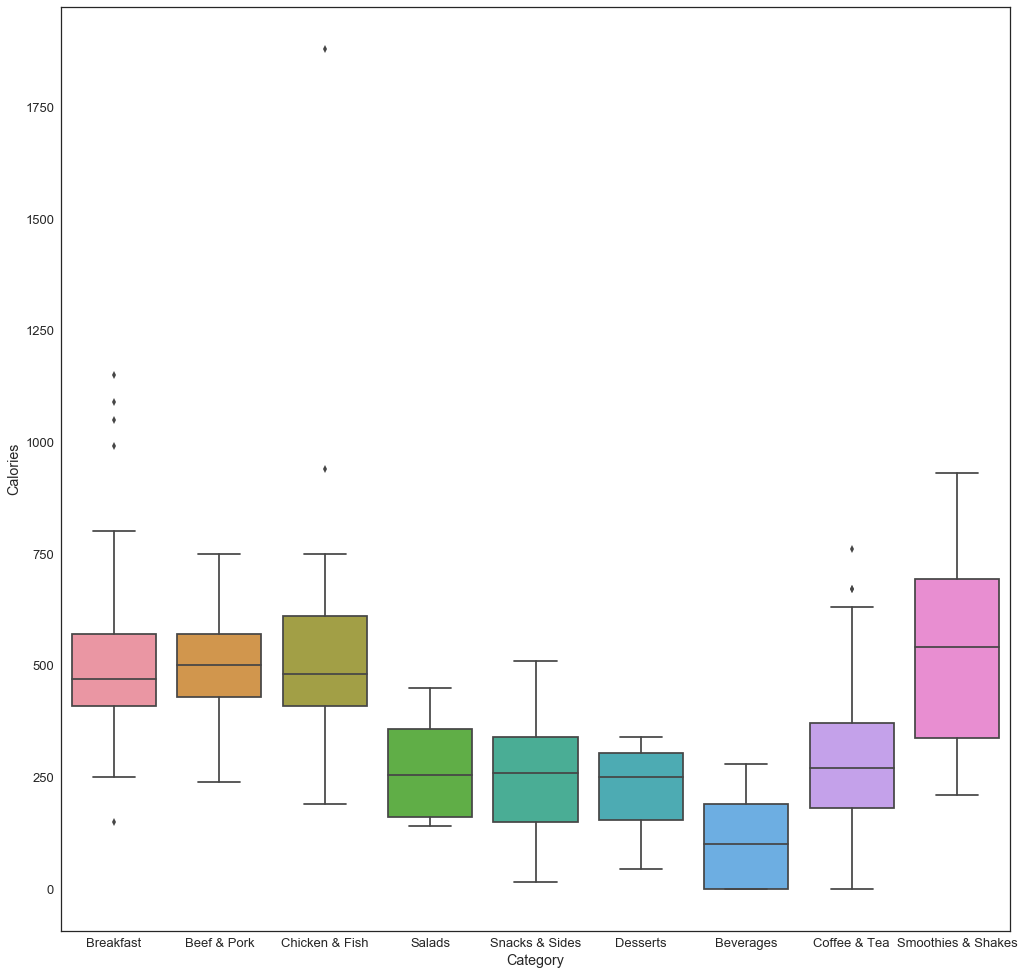

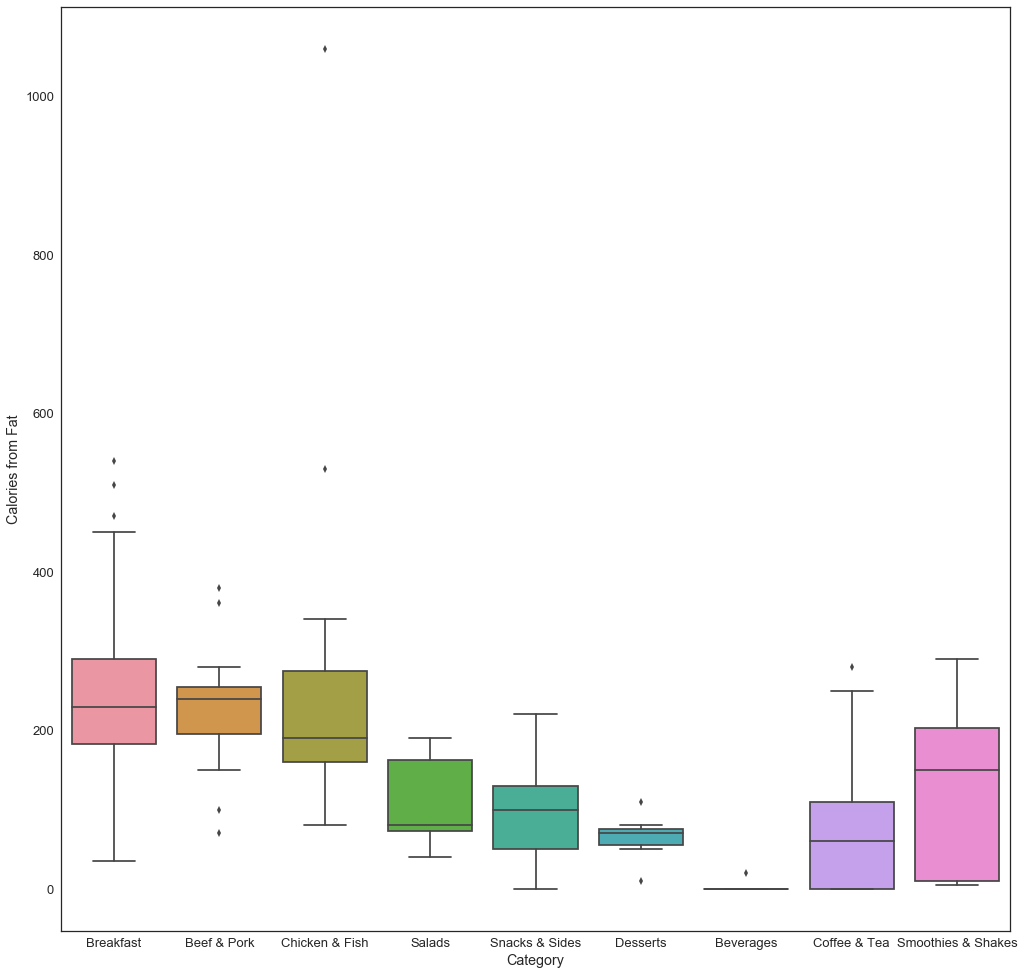

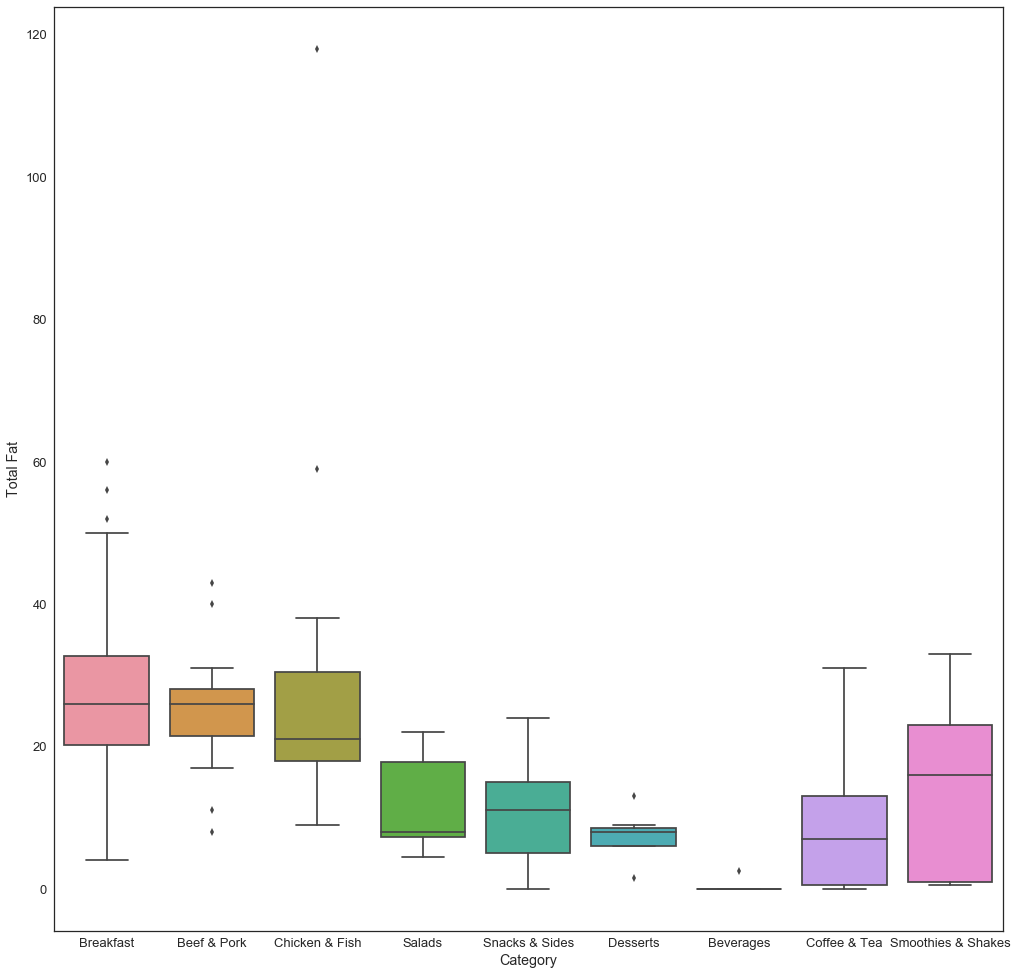

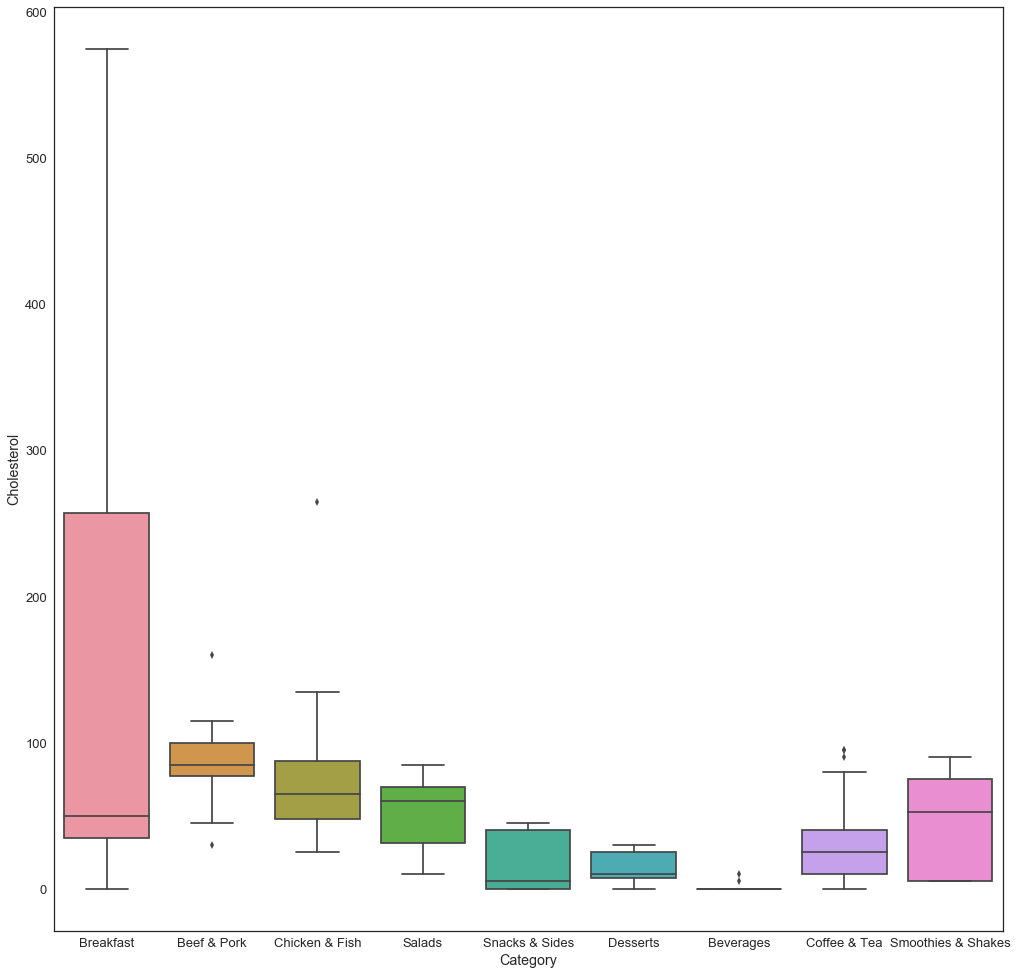

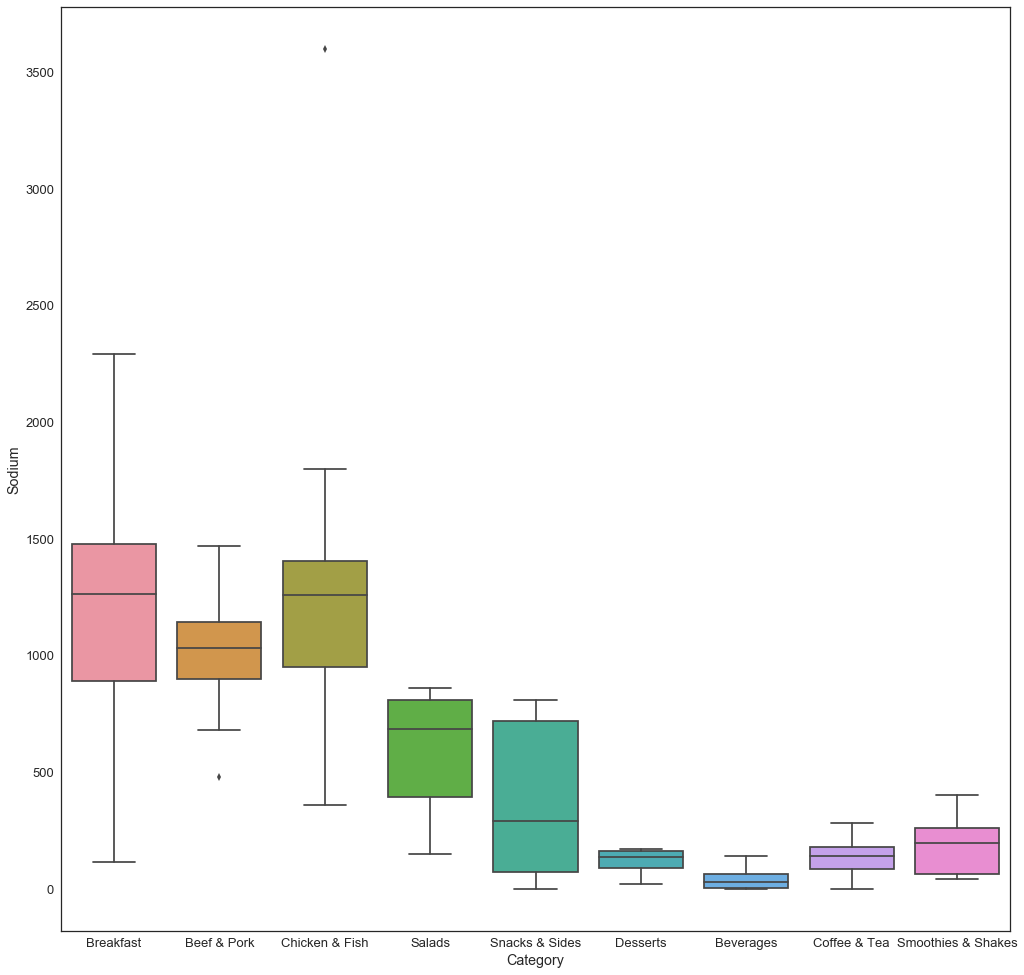

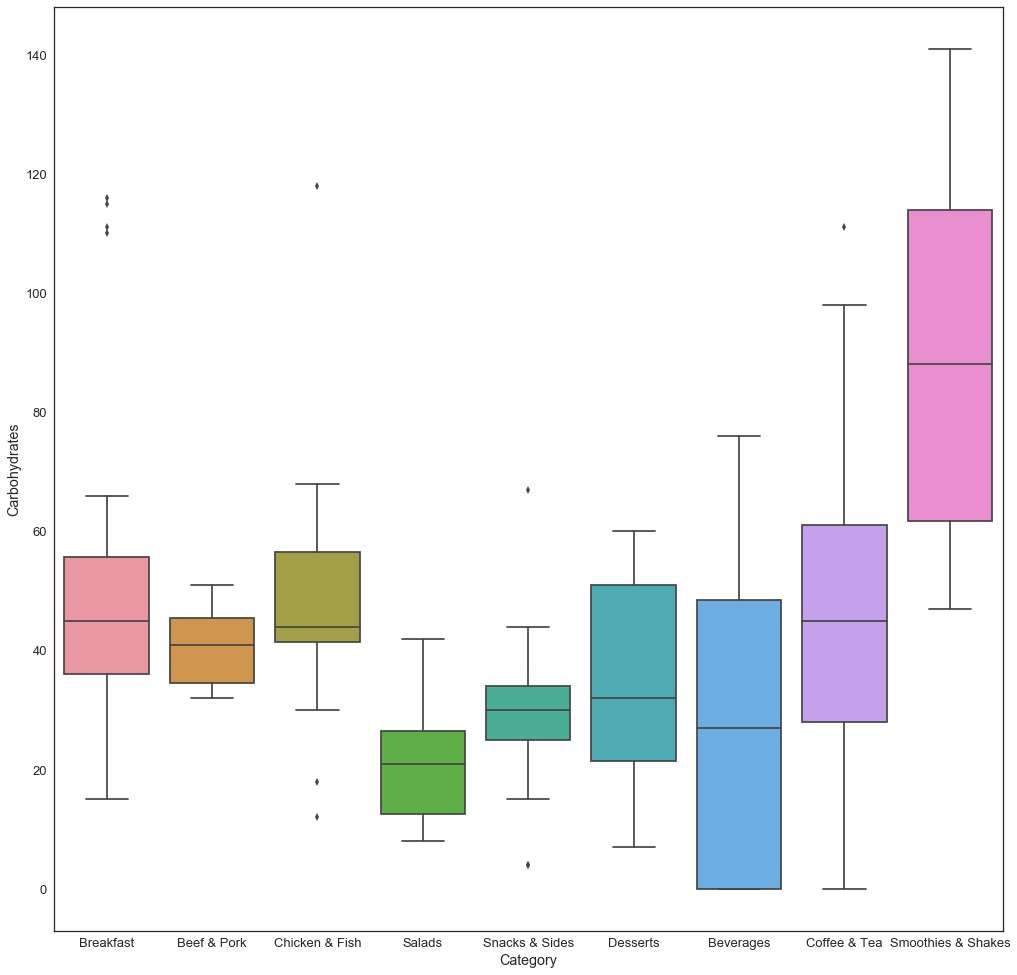

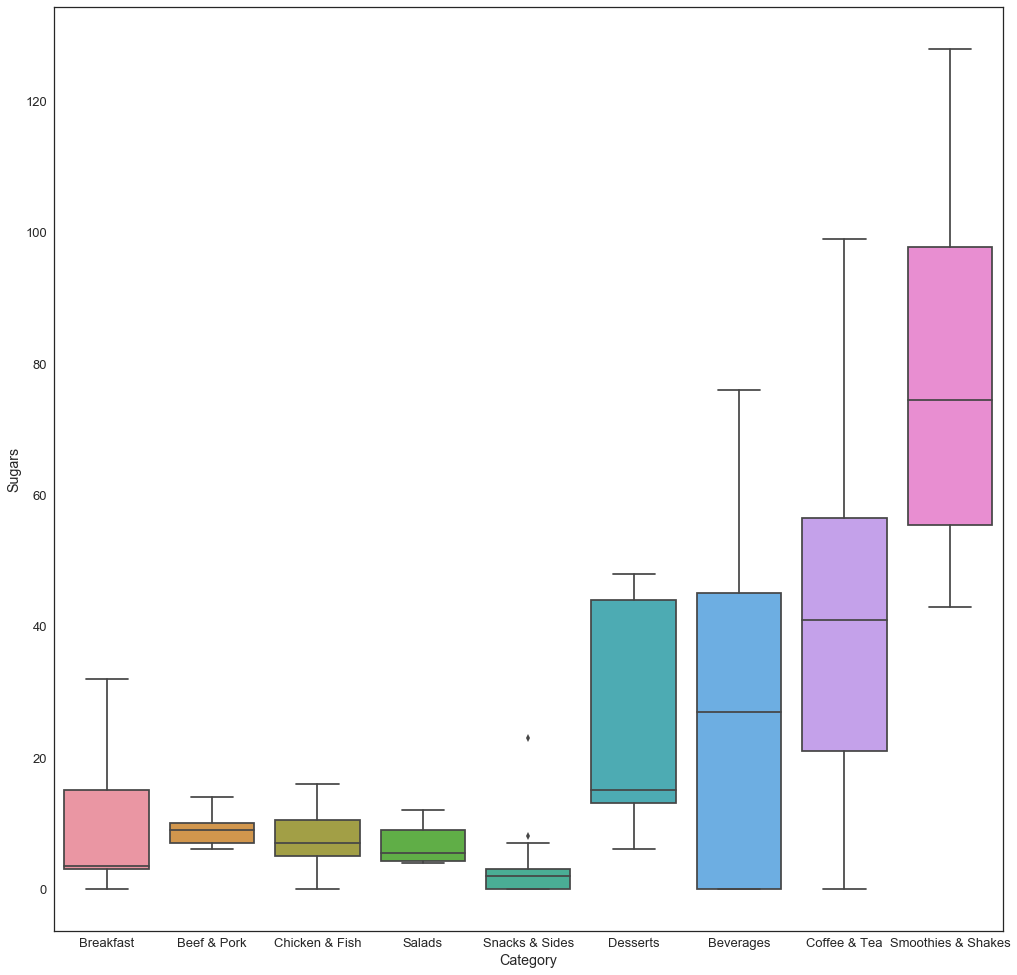

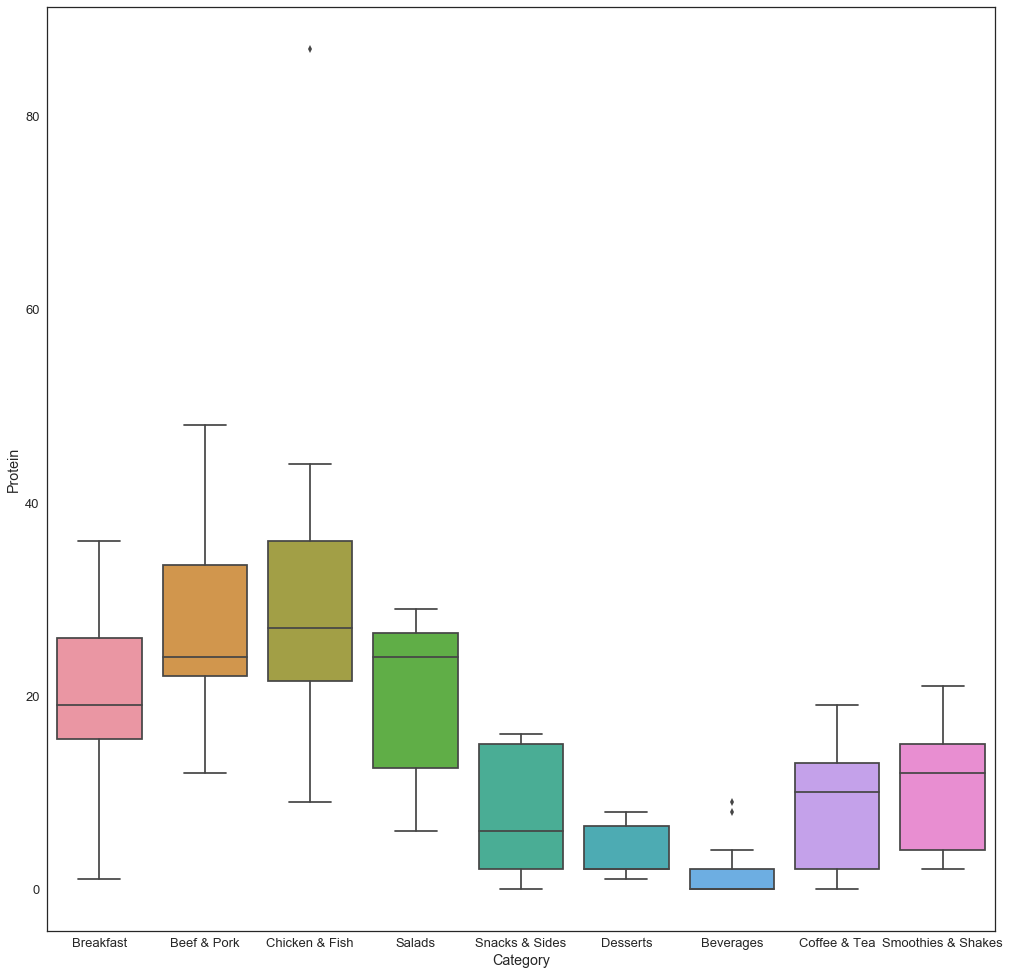

In [231]:
# want to see quartiles and outliers for each food category
for column in focus_columns[1:]:
    plt.figure(figsize=(17,17))

    sns.boxplot(x = "Category", y = column, data = mcd_menu)

In [246]:
# investigating outliers
mcd_outliers = {}
for column in focus_columns[1:]:
    mcd_outliers[column] = mcd_menu[mcd_menu[column] > mcd_menu[column].quantile(0.99)].index[:3]
mcd_outliers

{'Calories': Index(['Big Breakfast with Hotcakes (Regular Biscuit)',
        'Big Breakfast with Hotcakes (Large Biscuit)',
        'Chicken McNuggets (40 piece)'],
       dtype='object', name='Item'),
 'Calories from Fat': Index(['Big Breakfast with Hotcakes (Large Biscuit)',
        'Chicken McNuggets (20 piece)', 'Chicken McNuggets (40 piece)'],
       dtype='object', name='Item'),
 'Carbohydrates': Index(['Strawberry Shake (Large)', 'Chocolate Shake (Large)',
        'McFlurry with M&M’s Candies (Medium)'],
       dtype='object', name='Item'),
 'Cholesterol': Index(['Big Breakfast with Hotcakes (Regular Biscuit)', 'Big Breakfast with Hotcakes (Large Biscuit)'], dtype='object', name='Item'),
 'Protein': Index(['Double Quarter Pounder with Cheese', 'Chicken McNuggets (20 piece)',
        'Chicken McNuggets (40 piece)'],
       dtype='object', name='Item'),
 'Serving Size': Index(['Chicken McNuggets (40 piece)', 'Dasani Water Bottle',
        'McFlurry with M&M’s Candies (Medium)'],
 

Findings from above:
* Breakfast:

In [157]:
# descriptive stats for main food items (excludes breakfast, sides, desserts, drinks)
mcd_menu[(mcd_menu['Category'] == 'Chicken & Fish') | (mcd_menu['Category'] == 'Beef & Pork') | (mcd_menu['Category'] == 'Salads')][focus_columns].describe()

Serving Size     Calories  Calories from Fat   Total Fat  Cholesterol  \
count     48.000000    48.000000          48.000000   48.000000    48.000000   
mean       6.541667   499.166667         220.000000   24.406250    76.145833   
std        4.292291   260.840159         154.313855   17.226481    40.452751   
min        0.000000   140.000000          40.000000    4.500000    10.000000   
25%        5.000000   380.000000         150.000000   16.750000    50.000000   
50%        7.000000   460.000000         195.000000   22.000000    72.500000   
75%        9.250000   592.500000         252.500000   28.250000    90.000000   
max       22.000000  1880.000000        1060.000000  118.000000   265.000000   

            Sodium  Carbohydrates     Sugars    Protein  
count    48.000000      48.000000  48.000000  48.000000  
mean   1100.000000      42.854167   7.729167  27.395833  
std     518.894078      17.531722   3.846743  12.928181  
min     150.000000       8.000000   0.000000   6.000000  
25%     835.000000      34.750000   6.000000  22.000000  
50%    1065.000000      42.000000   7.000000  27.000000  
75%    1325.000000      51.000000  10.000000  33.000000  
max    3600.000000     118.000000  16.000000  87.000000

Findings from above:
* Breakfast:

### Subway

/Users/alexschwartz/anaconda/lib/python3.5/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


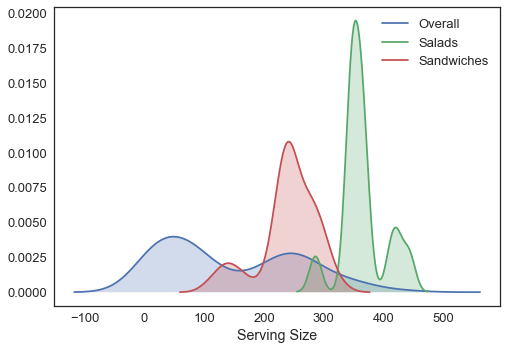

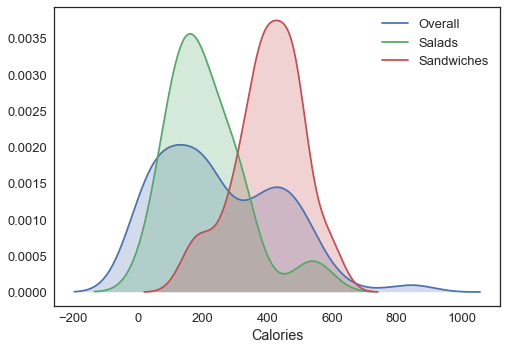

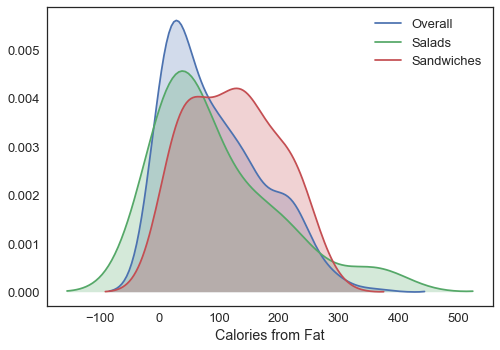

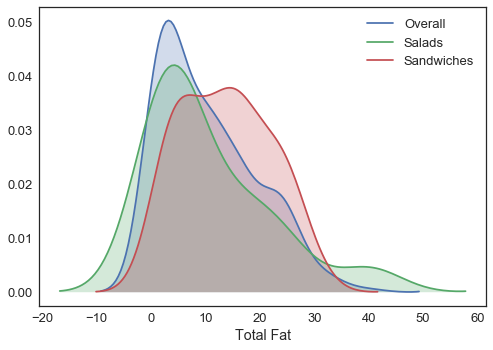

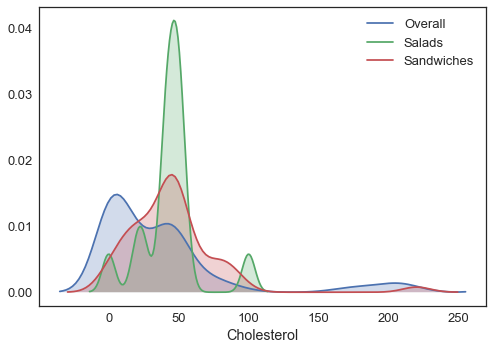

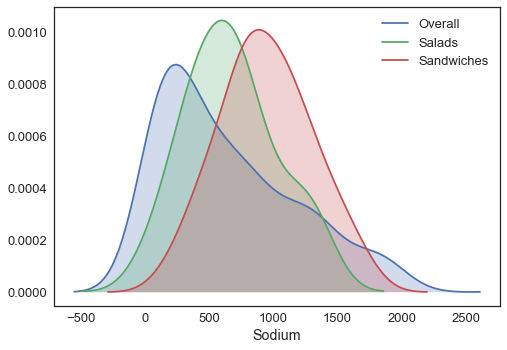

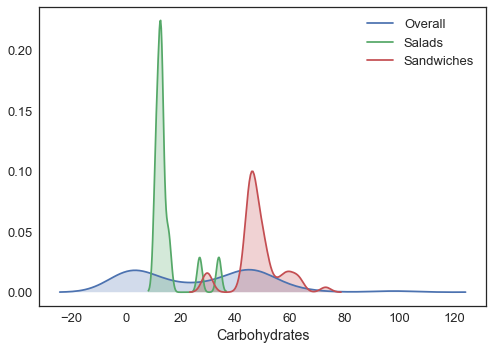

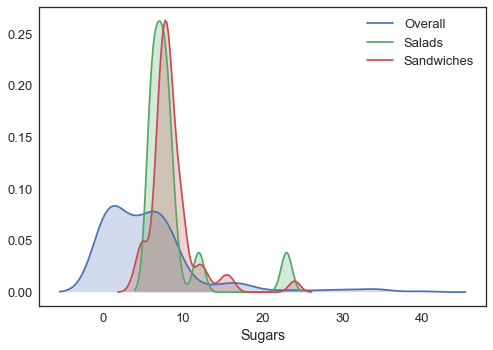

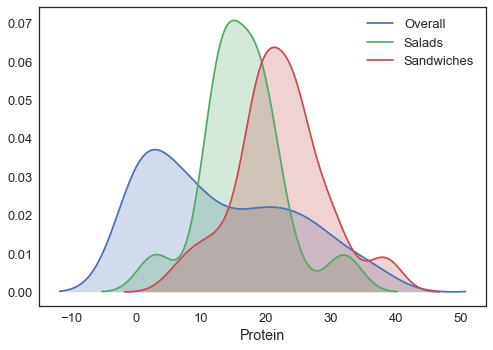

In [158]:
# investigating distribution of each nutrient for entire menu, salads, and sandwiches
for column in focus_columns[1:]:
    sns.distplot(subway_menu[column], hist=False, kde_kws={"shade": True}, label = 'Overall')
    sns.distplot(subway_menu[subway_menu.Category == 'Salad'][column], hist=False, kde_kws={"shade": True}, label = 'Salads')
    sns.distplot(subway_menu[subway_menu.Category == 'Sandwich'][column], hist=False, kde_kws={"shade": True}, label = 'Sandwiches')
    plt.figure()

Findings from above:
* Breakfast:

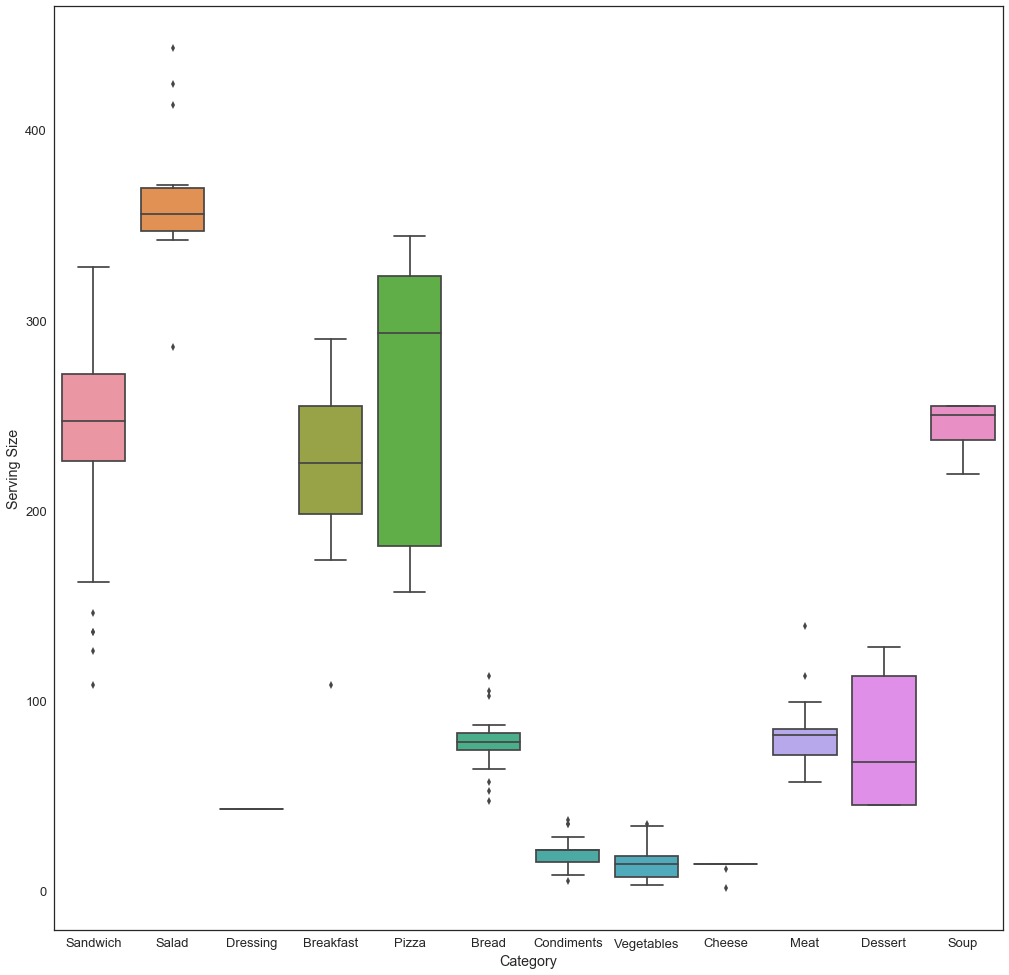

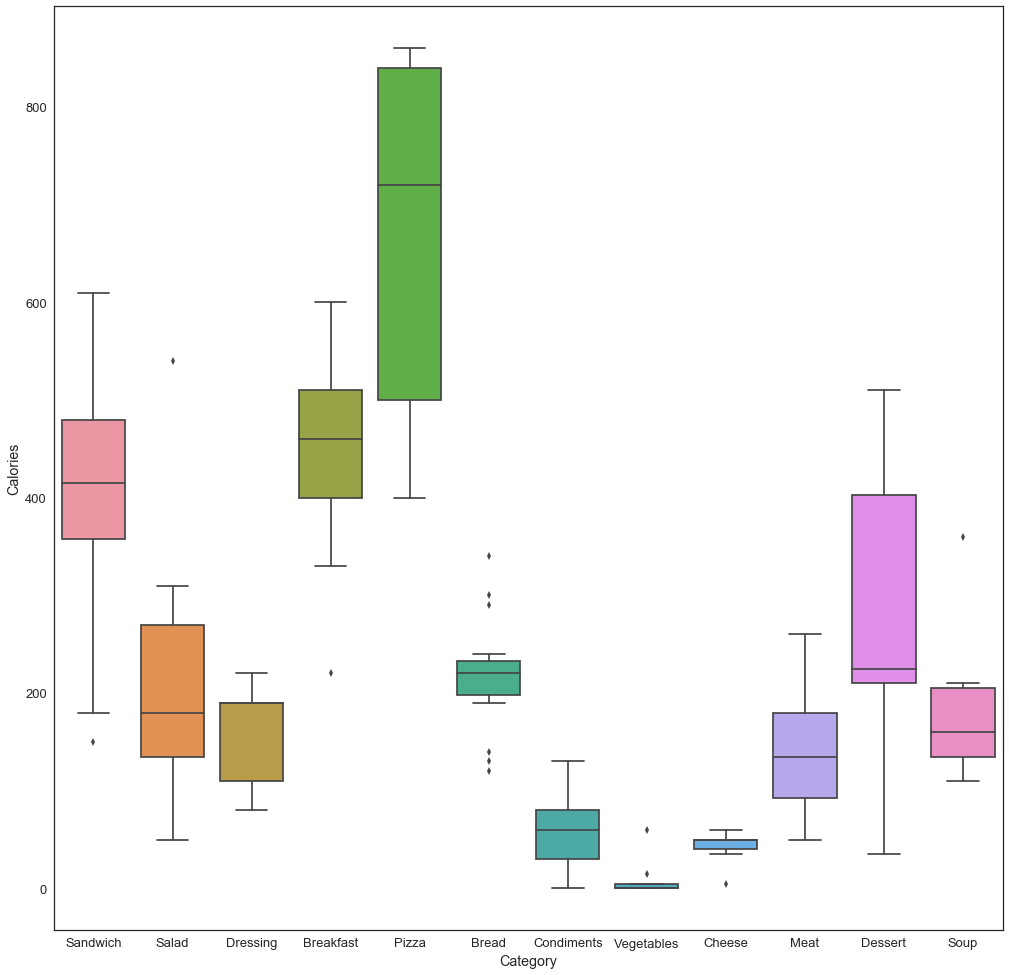

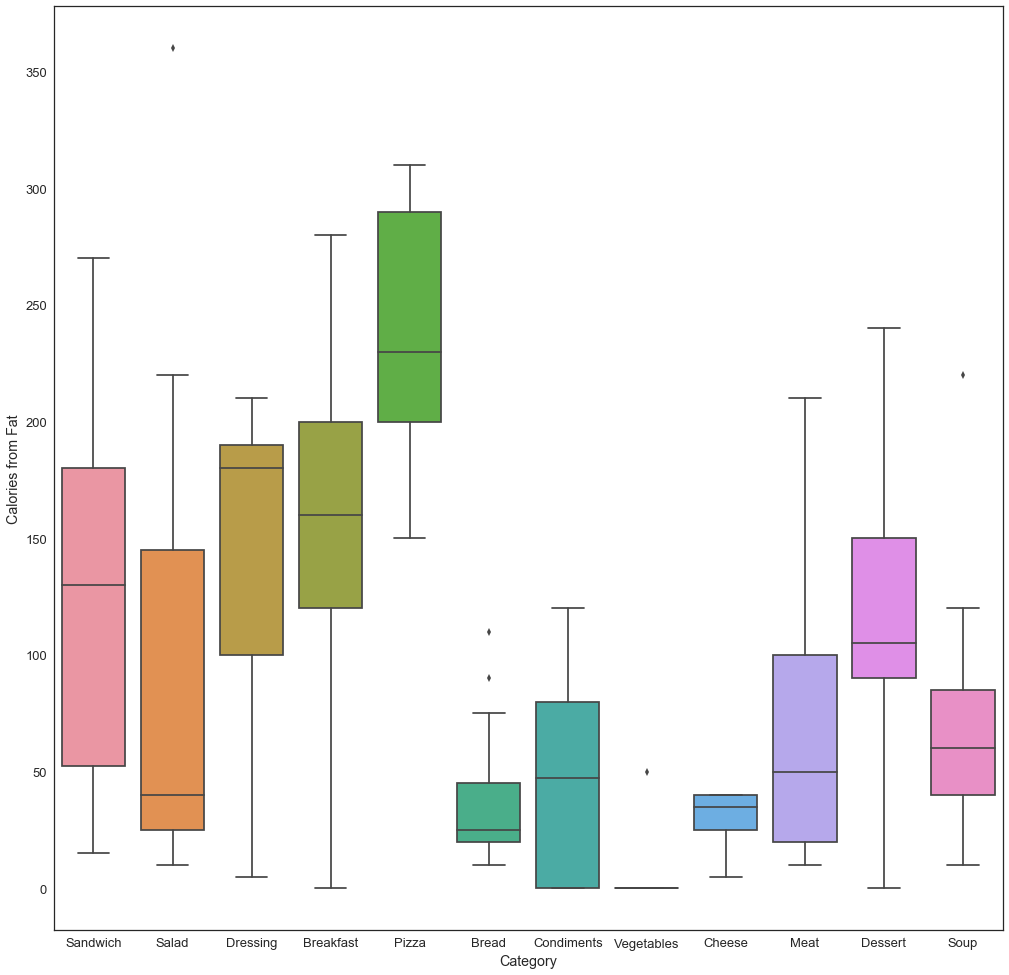

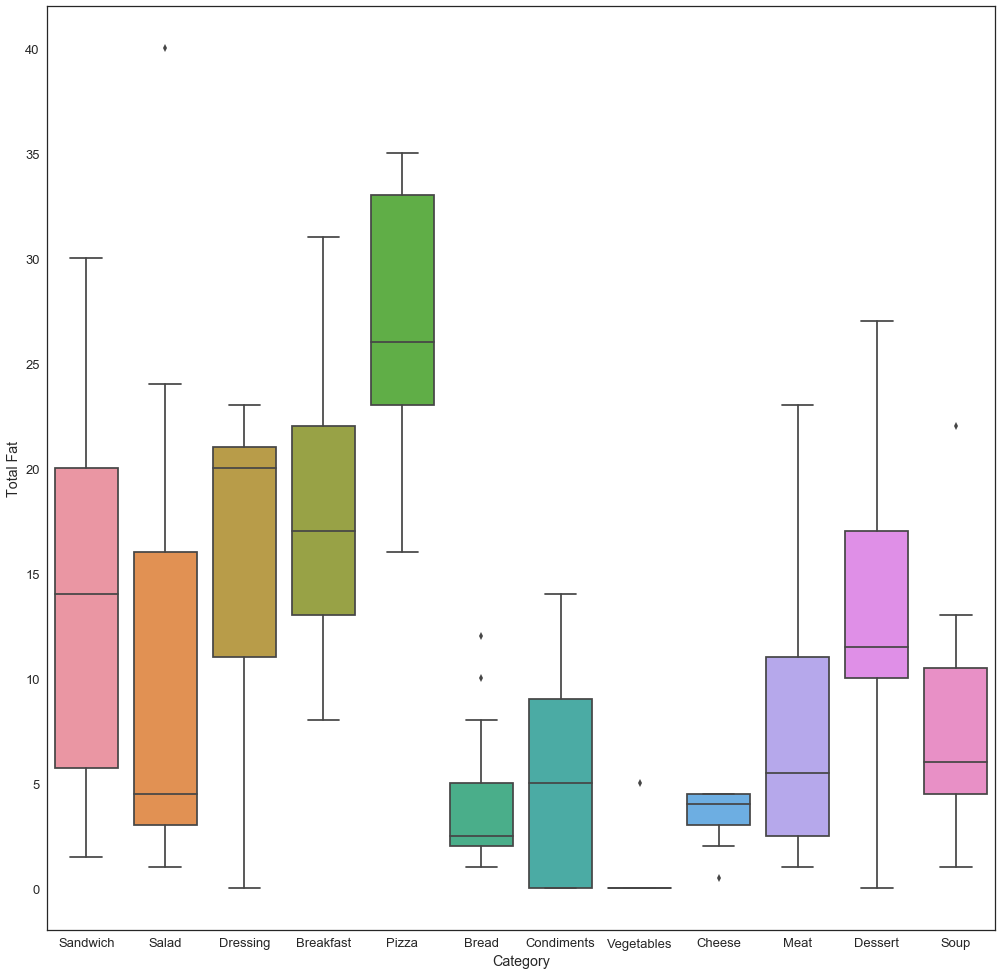

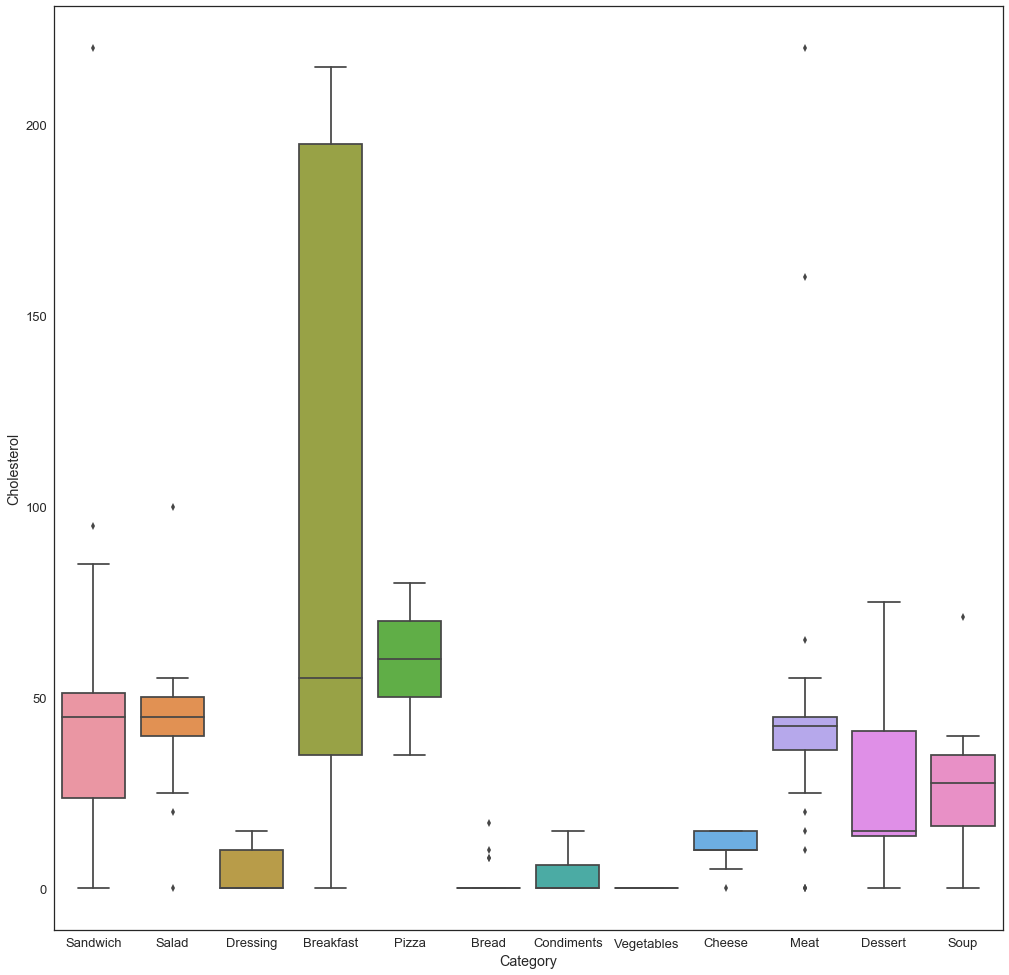

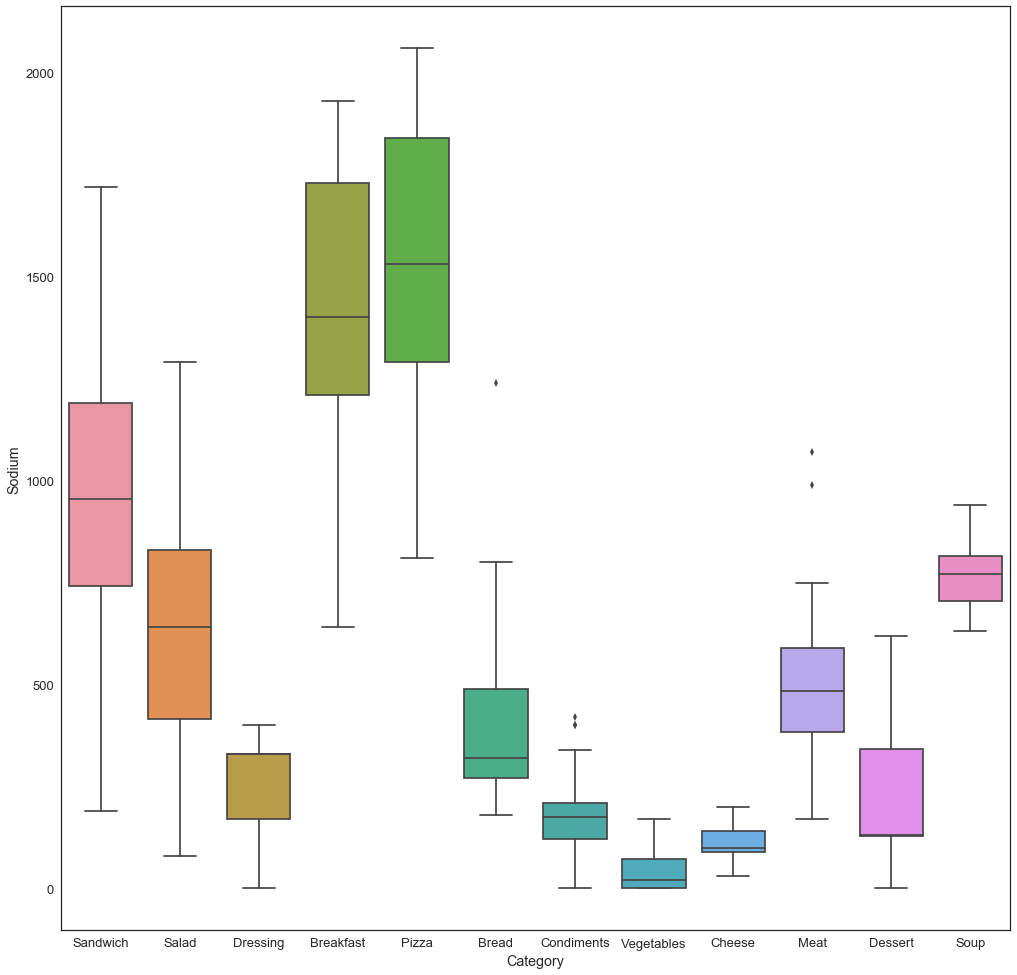

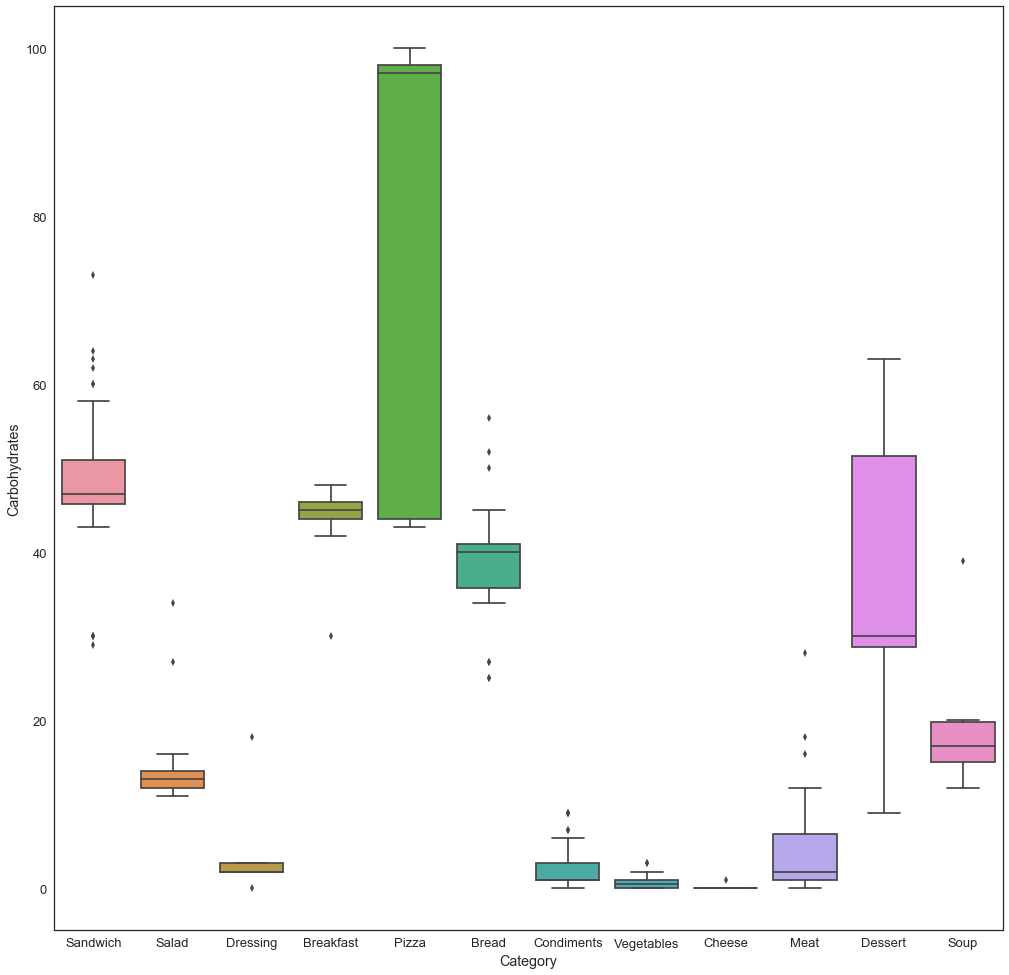

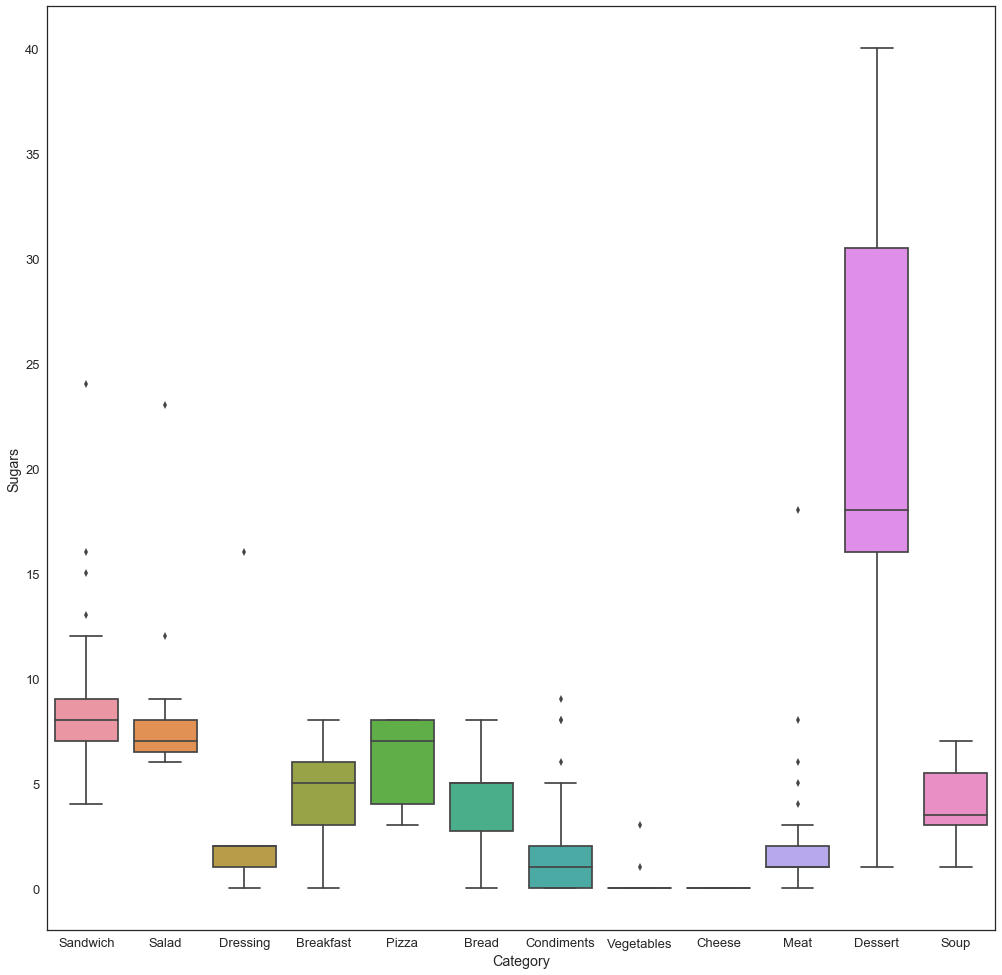

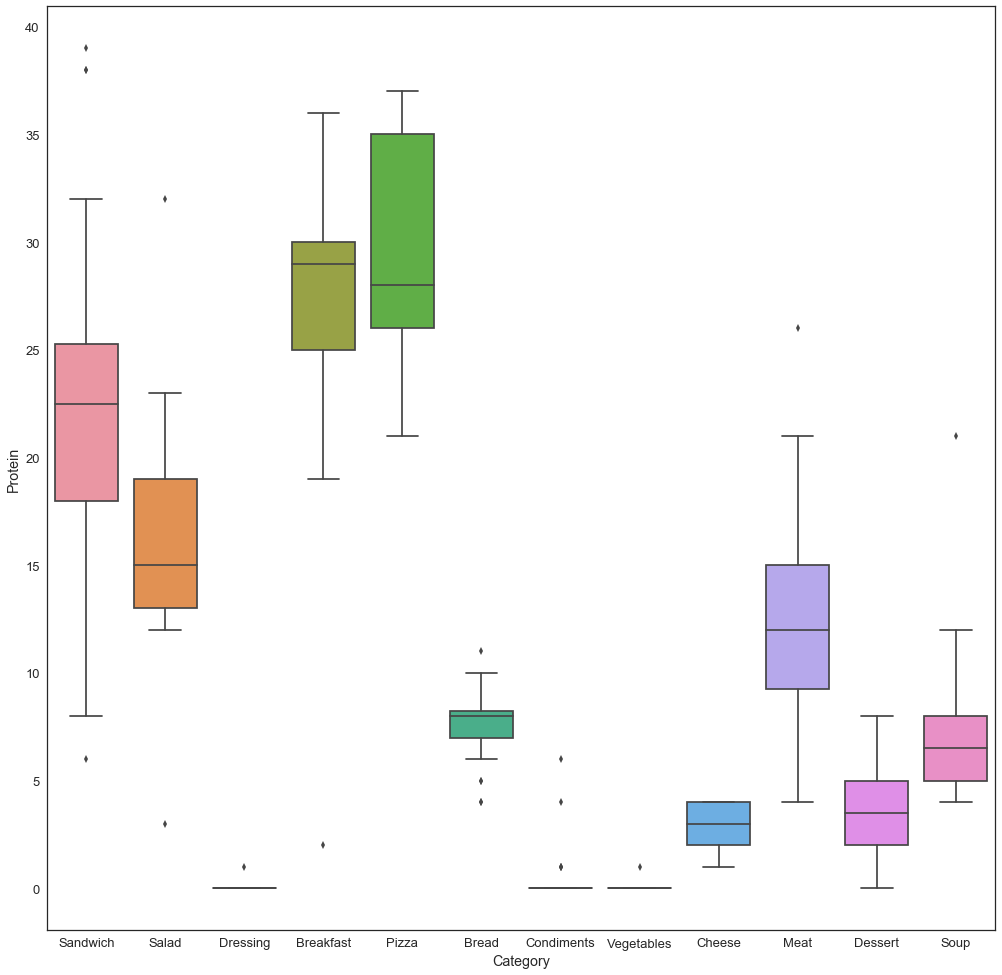

In [159]:
# want to see quartiles and outliers for each food category
for column in focus_columns[1:]:
    plt.figure(figsize=(17,17))
    sns.boxplot(x = "Category", y = column, data = subway_menu)

In [ ]:
# investigating outliers
subway_outliers = {}
for column in focus_columns[1:]:
    subway_outliers[column] = subway_outliers[subway_outliers[column] > subway_outliers[column].quantile(0.99)].index[:3]
subway_outliers

Findings from above:
* Breakfast:

In [160]:
# descriptive stats for main food items (excludes breakfast, sides, desserts, dressing, vegetables, cheese, meat, bread)
subway_menu[(subway_menu['Category'] == 'Sandwich') | (subway_menu['Category'] == 'Salad') | (subway_menu['Category'] == 'Pizza')][focus_columns].describe()

Serving Size    Calories  Calories from Fat  Total Fat  Cholesterol  \
count     76.000000   76.000000          76.000000  76.000000    76.000000   
mean     266.960526  396.052632         131.644737  14.625000    46.315789   
std       70.393644  172.526937          86.627125   9.686115    30.390442   
min      108.000000   50.000000          10.000000   1.000000     0.000000   
25%      232.250000  305.000000          40.000000   5.000000    30.000000   
50%      260.000000  400.000000         135.000000  15.000000    45.000000   
75%      311.000000  482.500000         202.500000  23.000000    55.000000   
max      443.000000  860.000000         360.000000  40.000000   220.000000   

            Sodium  Carbohydrates     Sugars    Protein  
count    76.000000      76.000000  76.000000  76.000000  
mean    954.605263      44.828947   8.289474  21.934211  
std     425.492470      20.674228   3.361808   7.663481  
min      80.000000      11.000000   3.000000   3.000000  
25%     657.500000      40.750000   7.000000  18.000000  
50%     890.000000      46.000000   8.000000  21.000000  
75%    1272.500000      50.250000   9.000000  26.000000  
max    2060.000000     100.000000  24.000000  39.000000

Findings from above:
* Breakfast:

### Combined

In [ ]:
for column in focus_columns[1:]:
    sns.distplot(combined_menu[combined_menu.Restaurant == 'McDonalds'][column], hist=False, kde_kws={"shade": True}, label = 'McDonalds')
    sns.distplot(combined_menu[combined_menu.Restaurant == 'Subway'][column], hist=False, kde_kws={"shade": True}, label = 'Subway')
    plt.figure()

Findings from above:
* Breakfast:

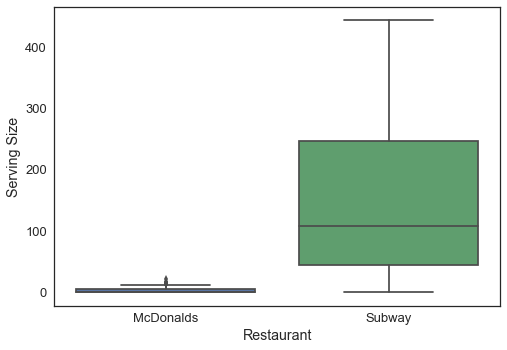

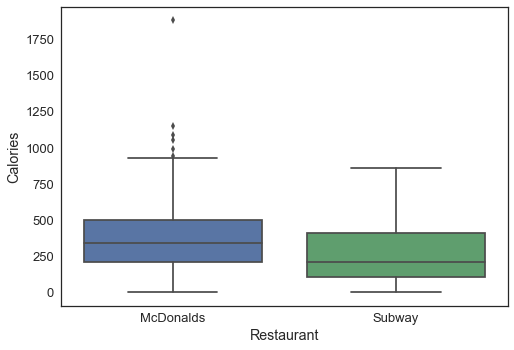

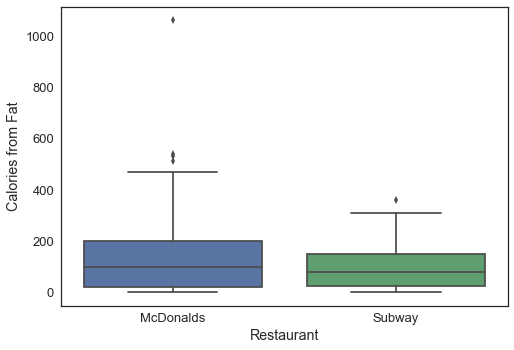

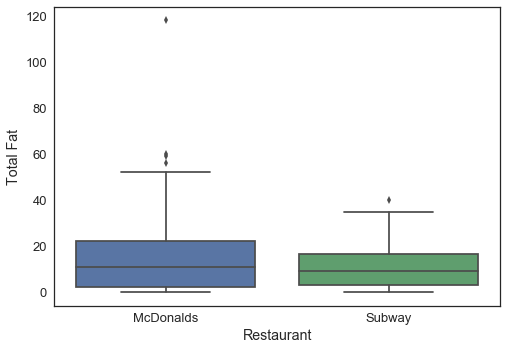

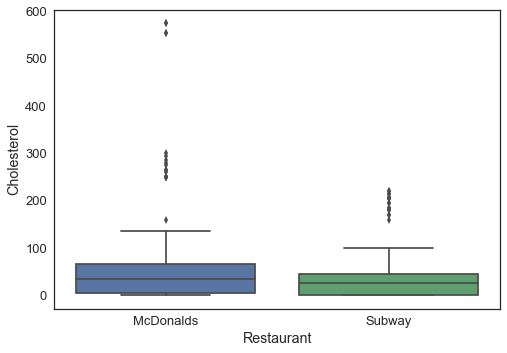

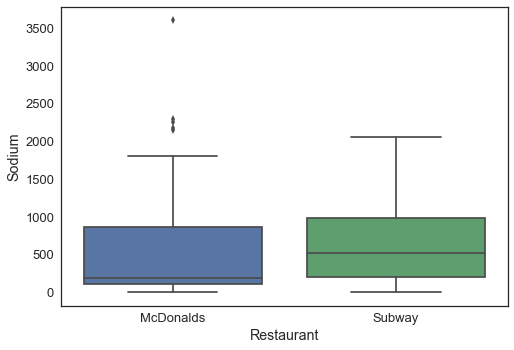

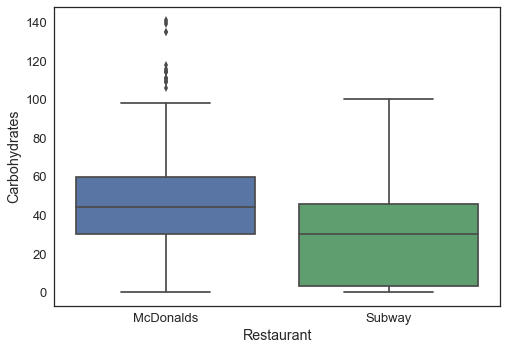

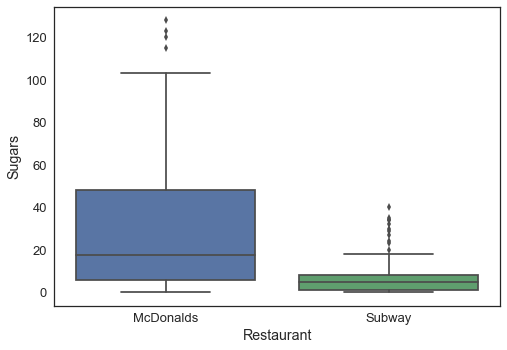

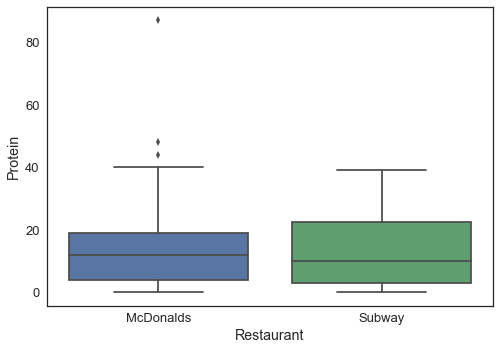

In [161]:
for column in focus_columns[1:]:
    sns.boxplot(x='Restaurant', y=column, data=combined_menu)
    plt.figure()

In [ ]:
# investigating outliers
combo_outliers = {}
for column in focus_columns[1:]:
    combined_menu[column] = combined_menu[combined_menu[column] > combined_menu[column].quantile(0.99)].index[:3]
combo_outliers

Findings from above:
* Breakfast:

In [248]:
# necessary to constrain by food category? metrics below likely not useful..
combined_menu[focus_columns].describe()

Serving Size     Calories  Calories from Fat   Total Fat  Cholesterol  \
count    515.000000   515.000000         515.000000  515.000000   515.000000   
mean      73.516505   312.805825         110.669903   12.324272    46.541748   
std      106.734867   222.909312         107.967100   11.985915    72.001998   
min        0.000000     0.000000           0.000000    0.000000     0.000000   
25%        0.000000   140.000000          25.000000    3.000000     5.000000   
50%       11.000000   280.000000          90.000000   10.000000    30.000000   
75%      103.500000   450.000000         180.000000   20.000000    50.000000   
max      443.000000  1880.000000        1060.000000  118.000000   575.000000   

            Sodium  Carbohydrates      Sugars     Protein  
count   515.000000     515.000000  515.000000  515.000000  
mean    571.271845      37.539806   17.765049   13.215534  
std     556.884996      27.588976   23.979830   11.319302  
min       0.000000       0.000000    0.000000    0.000000  
25%     135.000000      15.000000    3.000000    3.000000  
50%     330.000000      41.000000    7.000000   11.000000  
75%     955.000000      50.000000   22.000000   20.000000  
max    3600.000000     141.000000  128.000000   87.000000

## Pearson Correlation

### McDonald's

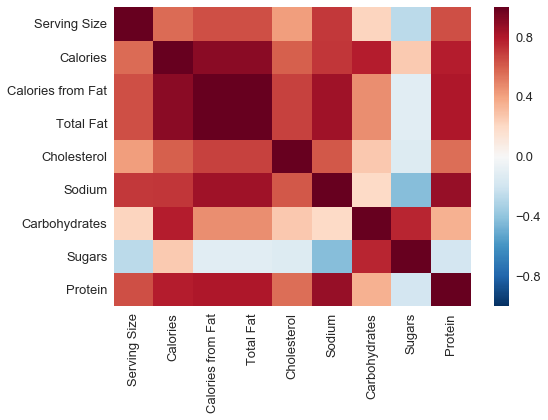

In [163]:
# are nutritients correlated with each other?
sns.heatmap(mcd_menu[focus_columns].corr(method='pearson', min_periods=1))

In [164]:
mcd_menu[focus_columns].corr(method='pearson', min_periods=1)

Serving Size  Calories  Calories from Fat  Total Fat  \
Serving Size           1.000000  0.569178           0.643061   0.641697   
Calories               0.569178  1.000000           0.904588   0.904409   
Calories from Fat      0.643061  0.904588           1.000000   0.999663   
Total Fat              0.641697  0.904409           0.999663   1.000000   
Cholesterol            0.418552  0.596399           0.682161   0.680547   
Sodium                 0.709808  0.712309           0.846624   0.846158   
Carbohydrates          0.221708  0.781539           0.461672   0.461213   
Sugars                -0.269237  0.259598          -0.115285  -0.115446   
Protein                0.644003  0.787847           0.807913   0.807773   

                   Cholesterol    Sodium  Carbohydrates    Sugars   Protein  
Serving Size          0.418552  0.709808       0.221708 -0.269237  0.644003  
Calories              0.596399  0.712309       0.781539  0.259598  0.787847  
Calories from Fat     0.682161  0.846624       0.461672 -0.115285  0.807913  
Total Fat             0.680547  0.846158       0.461213 -0.115446  0.807773  
Cholesterol           1.000000  0.624362       0.270977 -0.135518  0.561561  
Sodium                0.624362  1.000000       0.200796 -0.426536  0.869802  
Carbohydrates         0.270977  0.200796       1.000000  0.762362  0.352122  
Sugars               -0.135518 -0.426536       0.762362  1.000000 -0.179940  
Protein               0.561561  0.869802       0.352122 -0.179940  1.000000

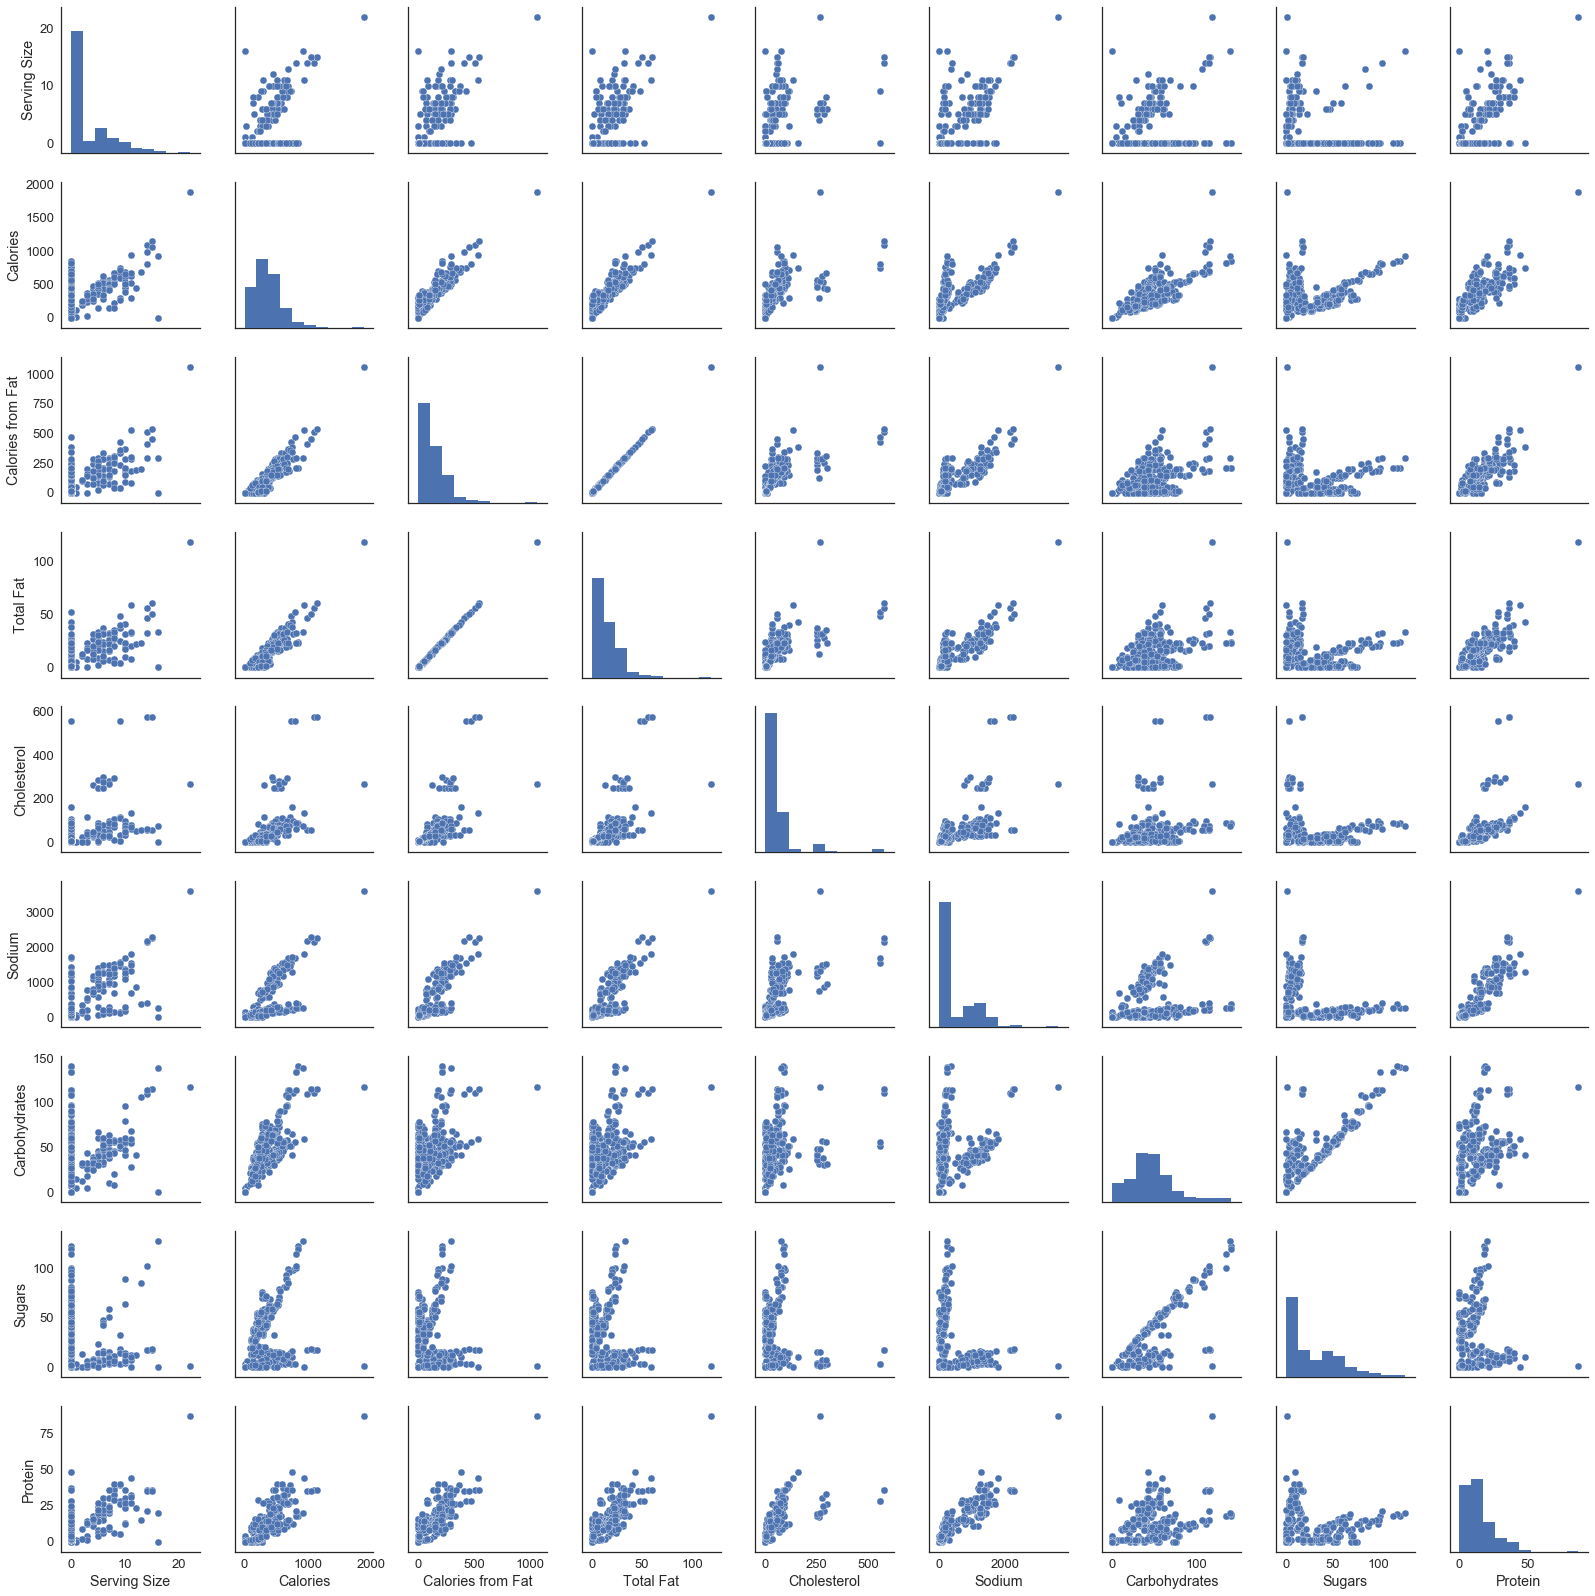

In [165]:
# what do data points actually look like?
sns.pairplot(mcd_menu[focus_columns])

### Subway

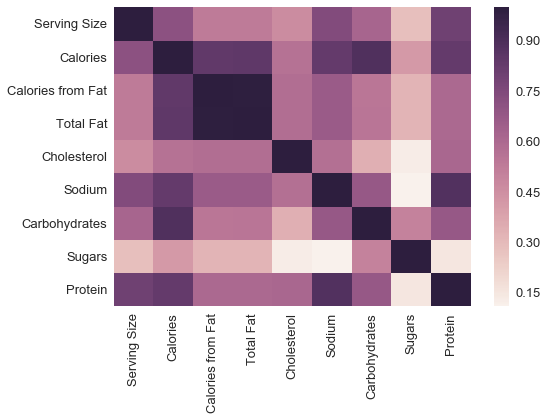

In [166]:
sns.heatmap(subway_menu[focus_columns].corr(method='pearson', min_periods=1))

In [167]:
subway_menu[focus_columns].corr(method='pearson', min_periods=1)

Serving Size  Calories  Calories from Fat  Total Fat  \
Serving Size           1.000000  0.714683           0.532596   0.532405   
Calories               0.714683  1.000000           0.841091   0.845164   
Calories from Fat      0.532596  0.841091           1.000000   0.996468   
Total Fat              0.532405  0.845164           0.996468   1.000000   
Cholesterol            0.465336  0.562661           0.580855   0.580373   
Sodium                 0.745483  0.831532           0.663590   0.666460   
Carbohydrates          0.618413  0.890733           0.547981   0.554161   
Sugars                 0.284307  0.419266           0.323945   0.322706   
Protein                0.797745  0.830123           0.602935   0.601811   

                   Cholesterol    Sodium  Carbohydrates    Sugars   Protein  
Serving Size          0.465336  0.745483       0.618413  0.284307  0.797745  
Calories              0.562661  0.831532       0.890733  0.419266  0.830123  
Calories from Fat     0.580855  0.663590       0.547981  0.323945  0.602935  
Total Fat             0.580373  0.666460       0.554161  0.322706  0.601811  
Cholesterol           1.000000  0.575232       0.341602  0.127215  0.611481  
Sodium                0.575232  1.000000       0.677708  0.110600  0.887194  
Carbohydrates         0.341602  0.677708       1.000000  0.502234  0.679421  
Sugars                0.127215  0.110600       0.502234  1.000000  0.149098  
Protein               0.611481  0.887194       0.679421  0.149098  1.000000

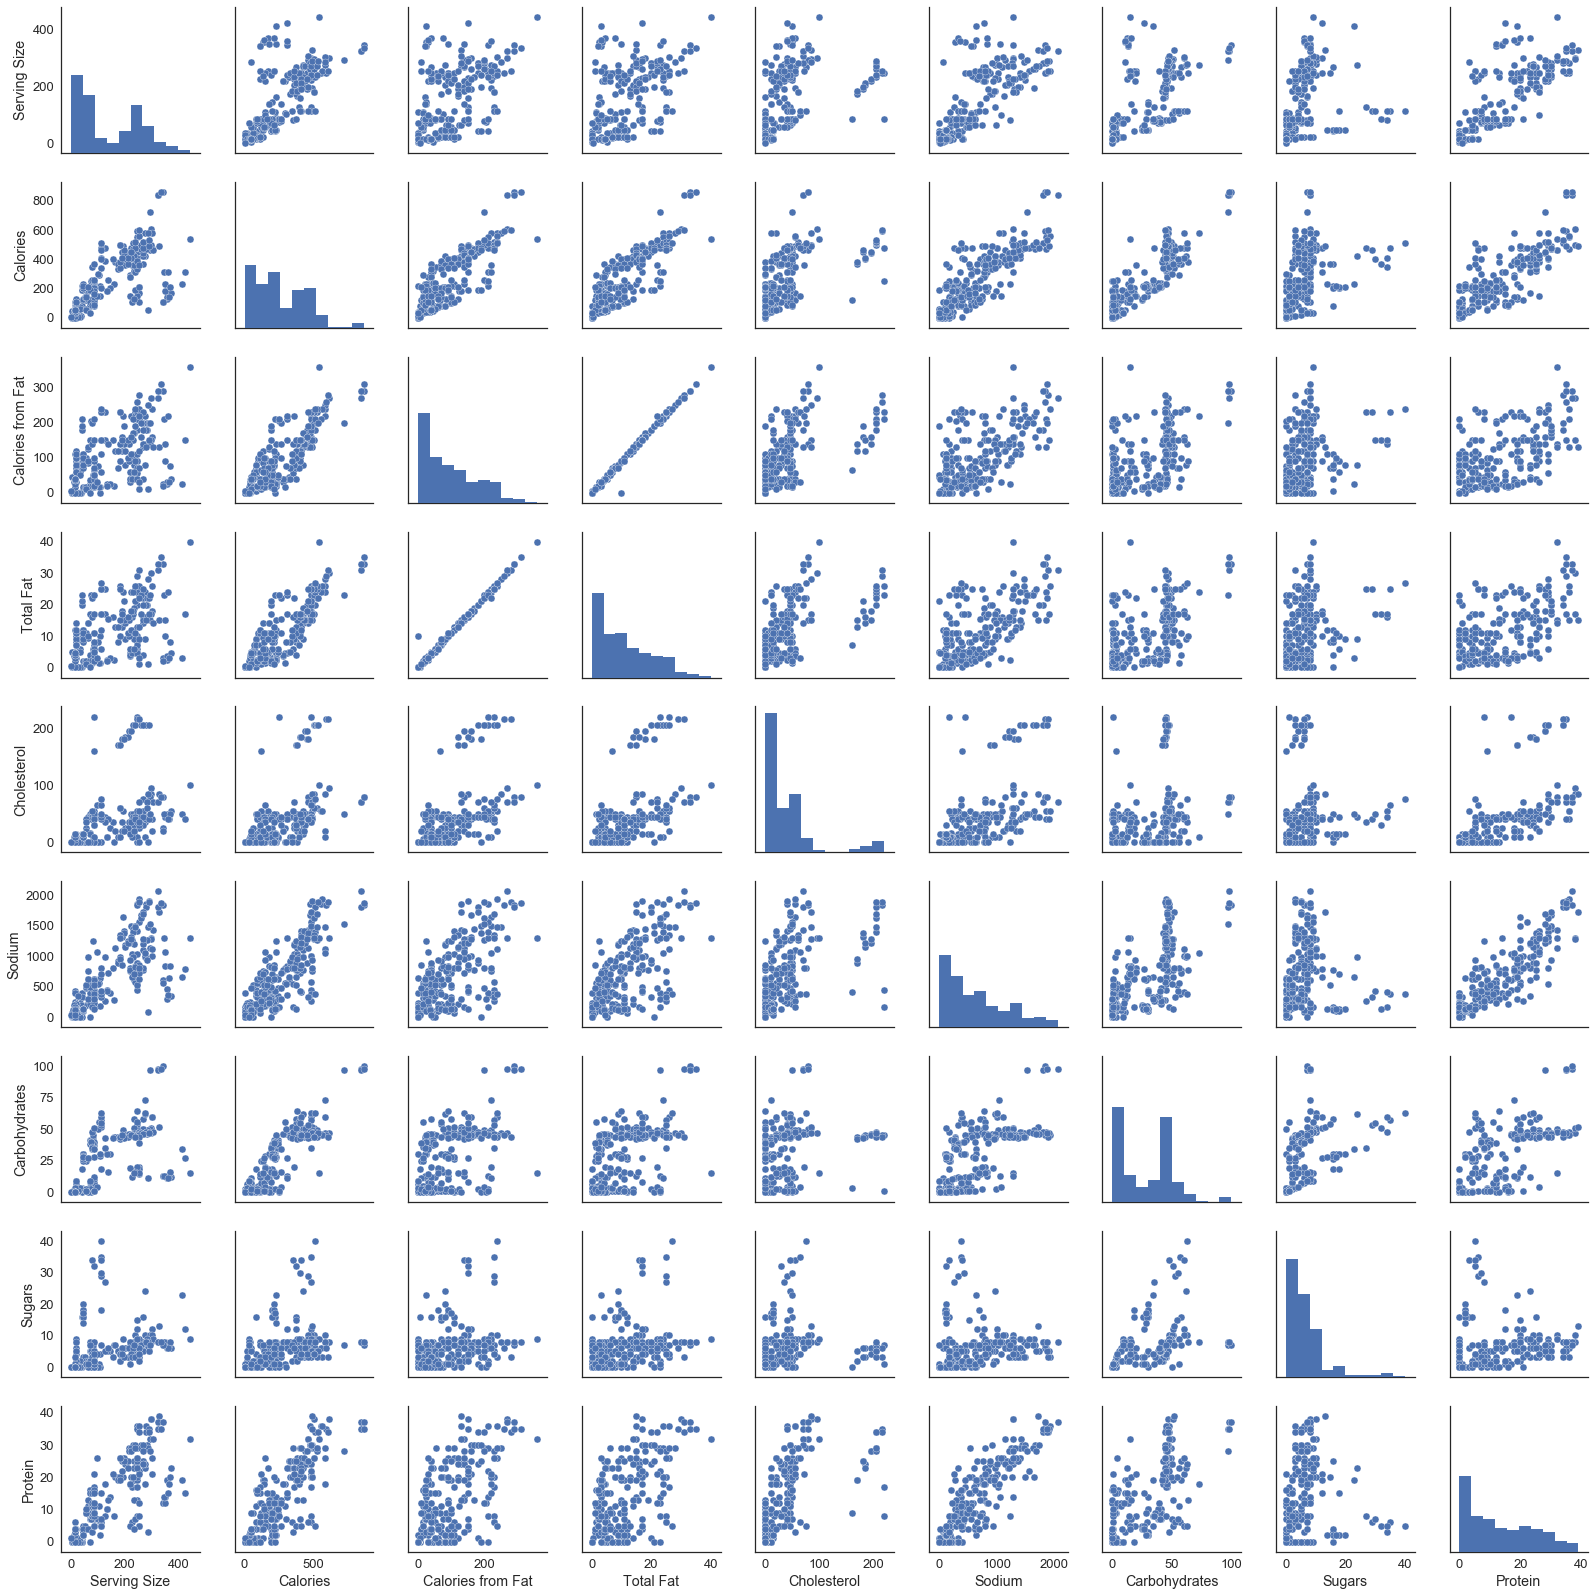

In [168]:
sns.pairplot(subway_menu[focus_columns])

## K-Means Clustering
To Do:
* Find way to visualize clusters
* Determine if 2 clusters is optimal given the different food categories. Should some be excluded?

### McDonald's

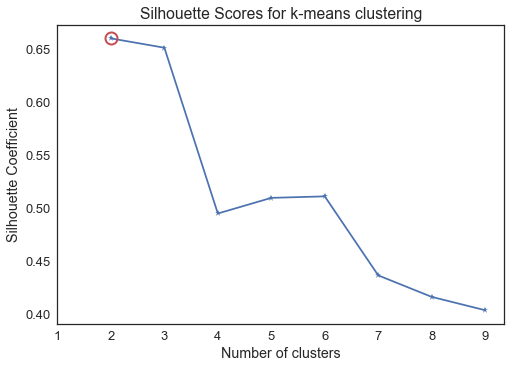

In [169]:
## Getting K for mcd_menu
X = mcd_menu[focus_columns[1:]].copy()
K = range(2,10)

KM = [skc.KMeans(n_clusters=k).fit(X) for k in K]
silh_scores = [skm.silhouette_score(X,km.labels_) for km in KM]
kIdx = np.argmax(silh_scores)

plt.plot(K, silh_scores, 'b*-')
plt.plot(K[kIdx], silh_scores[kIdx], marker='o', markersize=12, 
         markeredgewidth=2, markeredgecolor='r', markerfacecolor='None')
plt.xlim(1, plt.xlim()[1])
plt.xlabel('Number of clusters');
plt.ylabel('Silhouette Coefficient');
plt.title('Silhouette Scores for k-means clustering');

In [170]:
best_k = 2
kmeans_model = skc.KMeans(n_clusters = best_k)
kmeans_model.fit(X)
mcd_menu['labels'] = kmeans_model.labels_

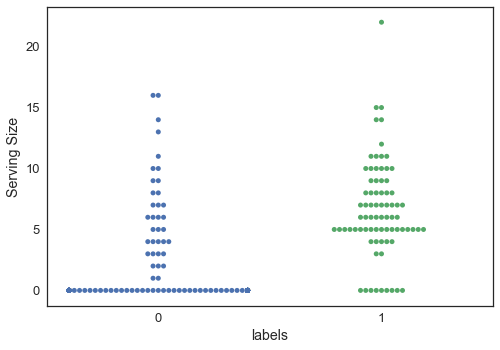

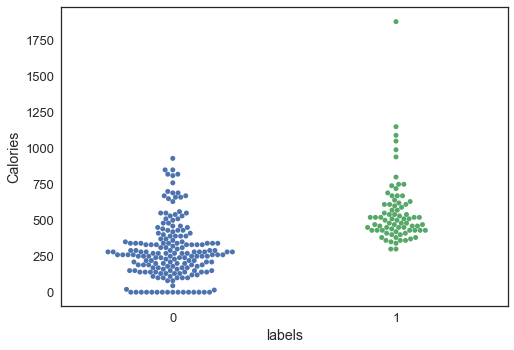

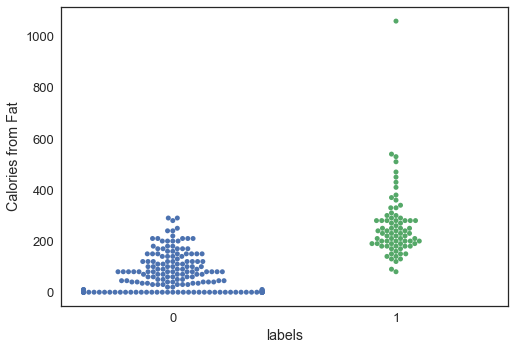

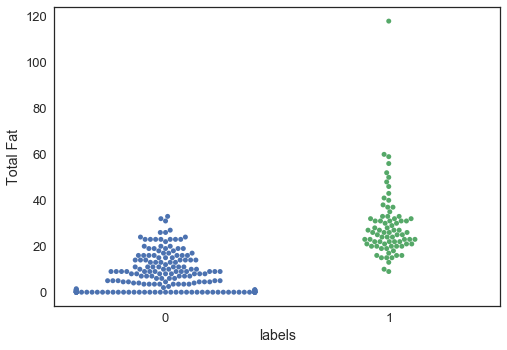

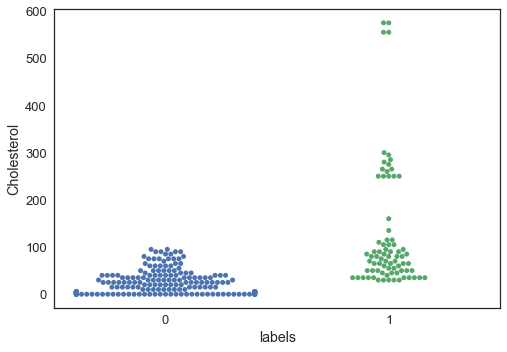

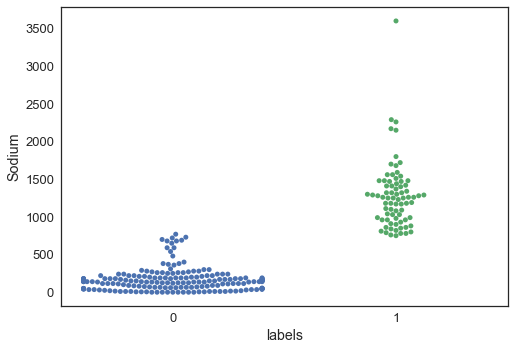

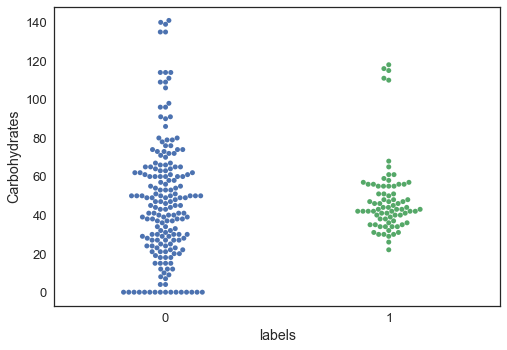

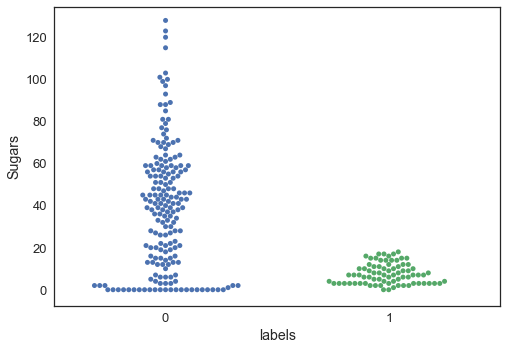

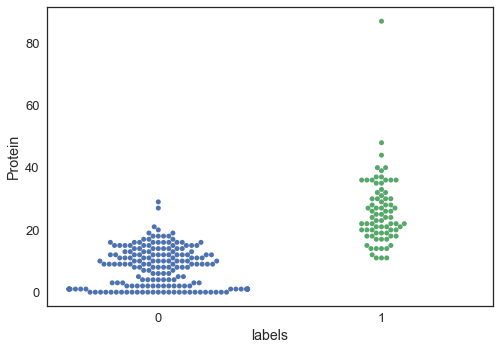

In [171]:
for column in focus_columns[1:]:
    sns.swarmplot(x='labels', y=column, data=mcd_menu)
    plt.figure()

Findings from above:
* Breakfast:

In [172]:
mcd_menu['labels'] = mcd_menu['labels'].map({0: 'zero', 1: 'one'})

In [173]:
from statsmodels.graphics.mosaicplot import mosaic
ct_mcd = pd.crosstab(mcd_menu['Category'], mcd_menu['labels']).T
# mosaic(ct_mcd, index=['one', 'zero'])
ct_mcd # can't get this to output a mosaic

Category  Beef & Pork  Beverages  Breakfast  Chicken & Fish  Coffee & Tea  \
labels                                                                      
one                13          0         36              24             0   
zero                2         27          6               3            95   

Category  Desserts  Salads  Smoothies & Shakes  Snacks & Sides  
labels                                                          
one              0       2                   0               2  
zero             7       4                  28              11

Findings from above:
* Breakfast

### Subway

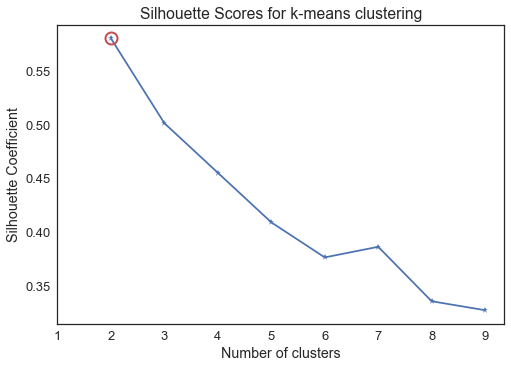

In [174]:
## Getting K for subway_menu
X = subway_menu[focus_columns[1:]].copy()
K = range(2,10)

KM = [skc.KMeans(n_clusters=k).fit(X) for k in K]
silh_scores = [skm.silhouette_score(X,km.labels_) for km in KM]
kIdx = np.argmax(silh_scores)

plt.plot(K, silh_scores, 'b*-')
plt.plot(K[kIdx], silh_scores[kIdx], marker='o', markersize=12, 
         markeredgewidth=2, markeredgecolor='r', markerfacecolor='None')
plt.xlim(1, plt.xlim()[1])
plt.xlabel('Number of clusters');
plt.ylabel('Silhouette Coefficient');
plt.title('Silhouette Scores for k-means clustering');

In [175]:
best_k = 2
kmeans_model = skc.KMeans(n_clusters = best_k)
kmeans_model.fit(X)
subway_menu['labels'] = kmeans_model.labels_

In [ ]:
for column in focus_columns[1:]:
    sns.swarmplot(x='labels', y=column, data=subway_menu)
    plt.figure()

Findings from above:
* Breakfast:

In [ ]:
subway_menu['labels'] = subway_menu['labels'].map({0: 'zero', 1: 'one'})

In [176]:
ct_subway = pd.crosstab(subway_menu['Category'], subway_menu['labels']).T
# mosaic(ct_mcd, index=['one', 'zero'])
ct_subway # can't get this to output a mosaic

Category  Bread  Breakfast  Cheese  Condiments  Dessert  Dressing  Meat  \
labels                                                                    
0             2         32       0           0        0         0     2   
1            22          1       9          32       20         5    28   

Category  Pizza  Salad  Sandwich  Soup  Vegetables  
labels                                              
0             9      6        38     5           0  
1             0      9        14     5          16

Findings from above:
* Breakfast

### Combined Menus

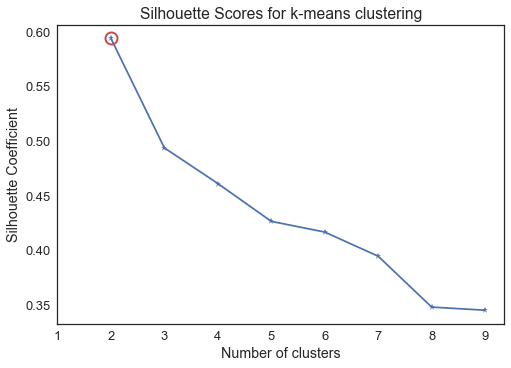

In [43]:
## Getting K for combined_menu
X = combined_menu[focus_columns[1:]].copy()
K = range(2,10)

KM = [skc.KMeans(n_clusters=k).fit(X) for k in K]
silh_scores = [skm.silhouette_score(X,km.labels_) for km in KM]
kIdx = np.argmax(silh_scores)

plt.plot(K, silh_scores, 'b*-')
plt.plot(K[kIdx], silh_scores[kIdx], marker='o', markersize=12, 
         markeredgewidth=2, markeredgecolor='r', markerfacecolor='None')
plt.xlim(1, plt.xlim()[1])
plt.xlabel('Number of clusters');
plt.ylabel('Silhouette Coefficient');
plt.title('Silhouette Scores for k-means clustering');

In [44]:
best_k = 2
kmeans_model = skc.KMeans(n_clusters = best_k)
kmeans_model.fit(X)
combined_menu['labels'] = kmeans_model.labels_

In [ ]:
for column in focus_columns[1:]:
    sns.swarmplot(x='labels', y=column, data=combined_menu)
    plt.figure()

In [ ]:
combined_menu['labels'] = combined_menu['labels'].map({0: 'zero', 1: 'one'})

In [ ]:
ct_combo = pd.crosstab(combined_menu['Category'], combined_menu['labels']).T
# mosaic(ct_mcd, index=['one', 'zero'])
ct_combo # can't get this to output a mosaic

## PCA Model

### McDonald's

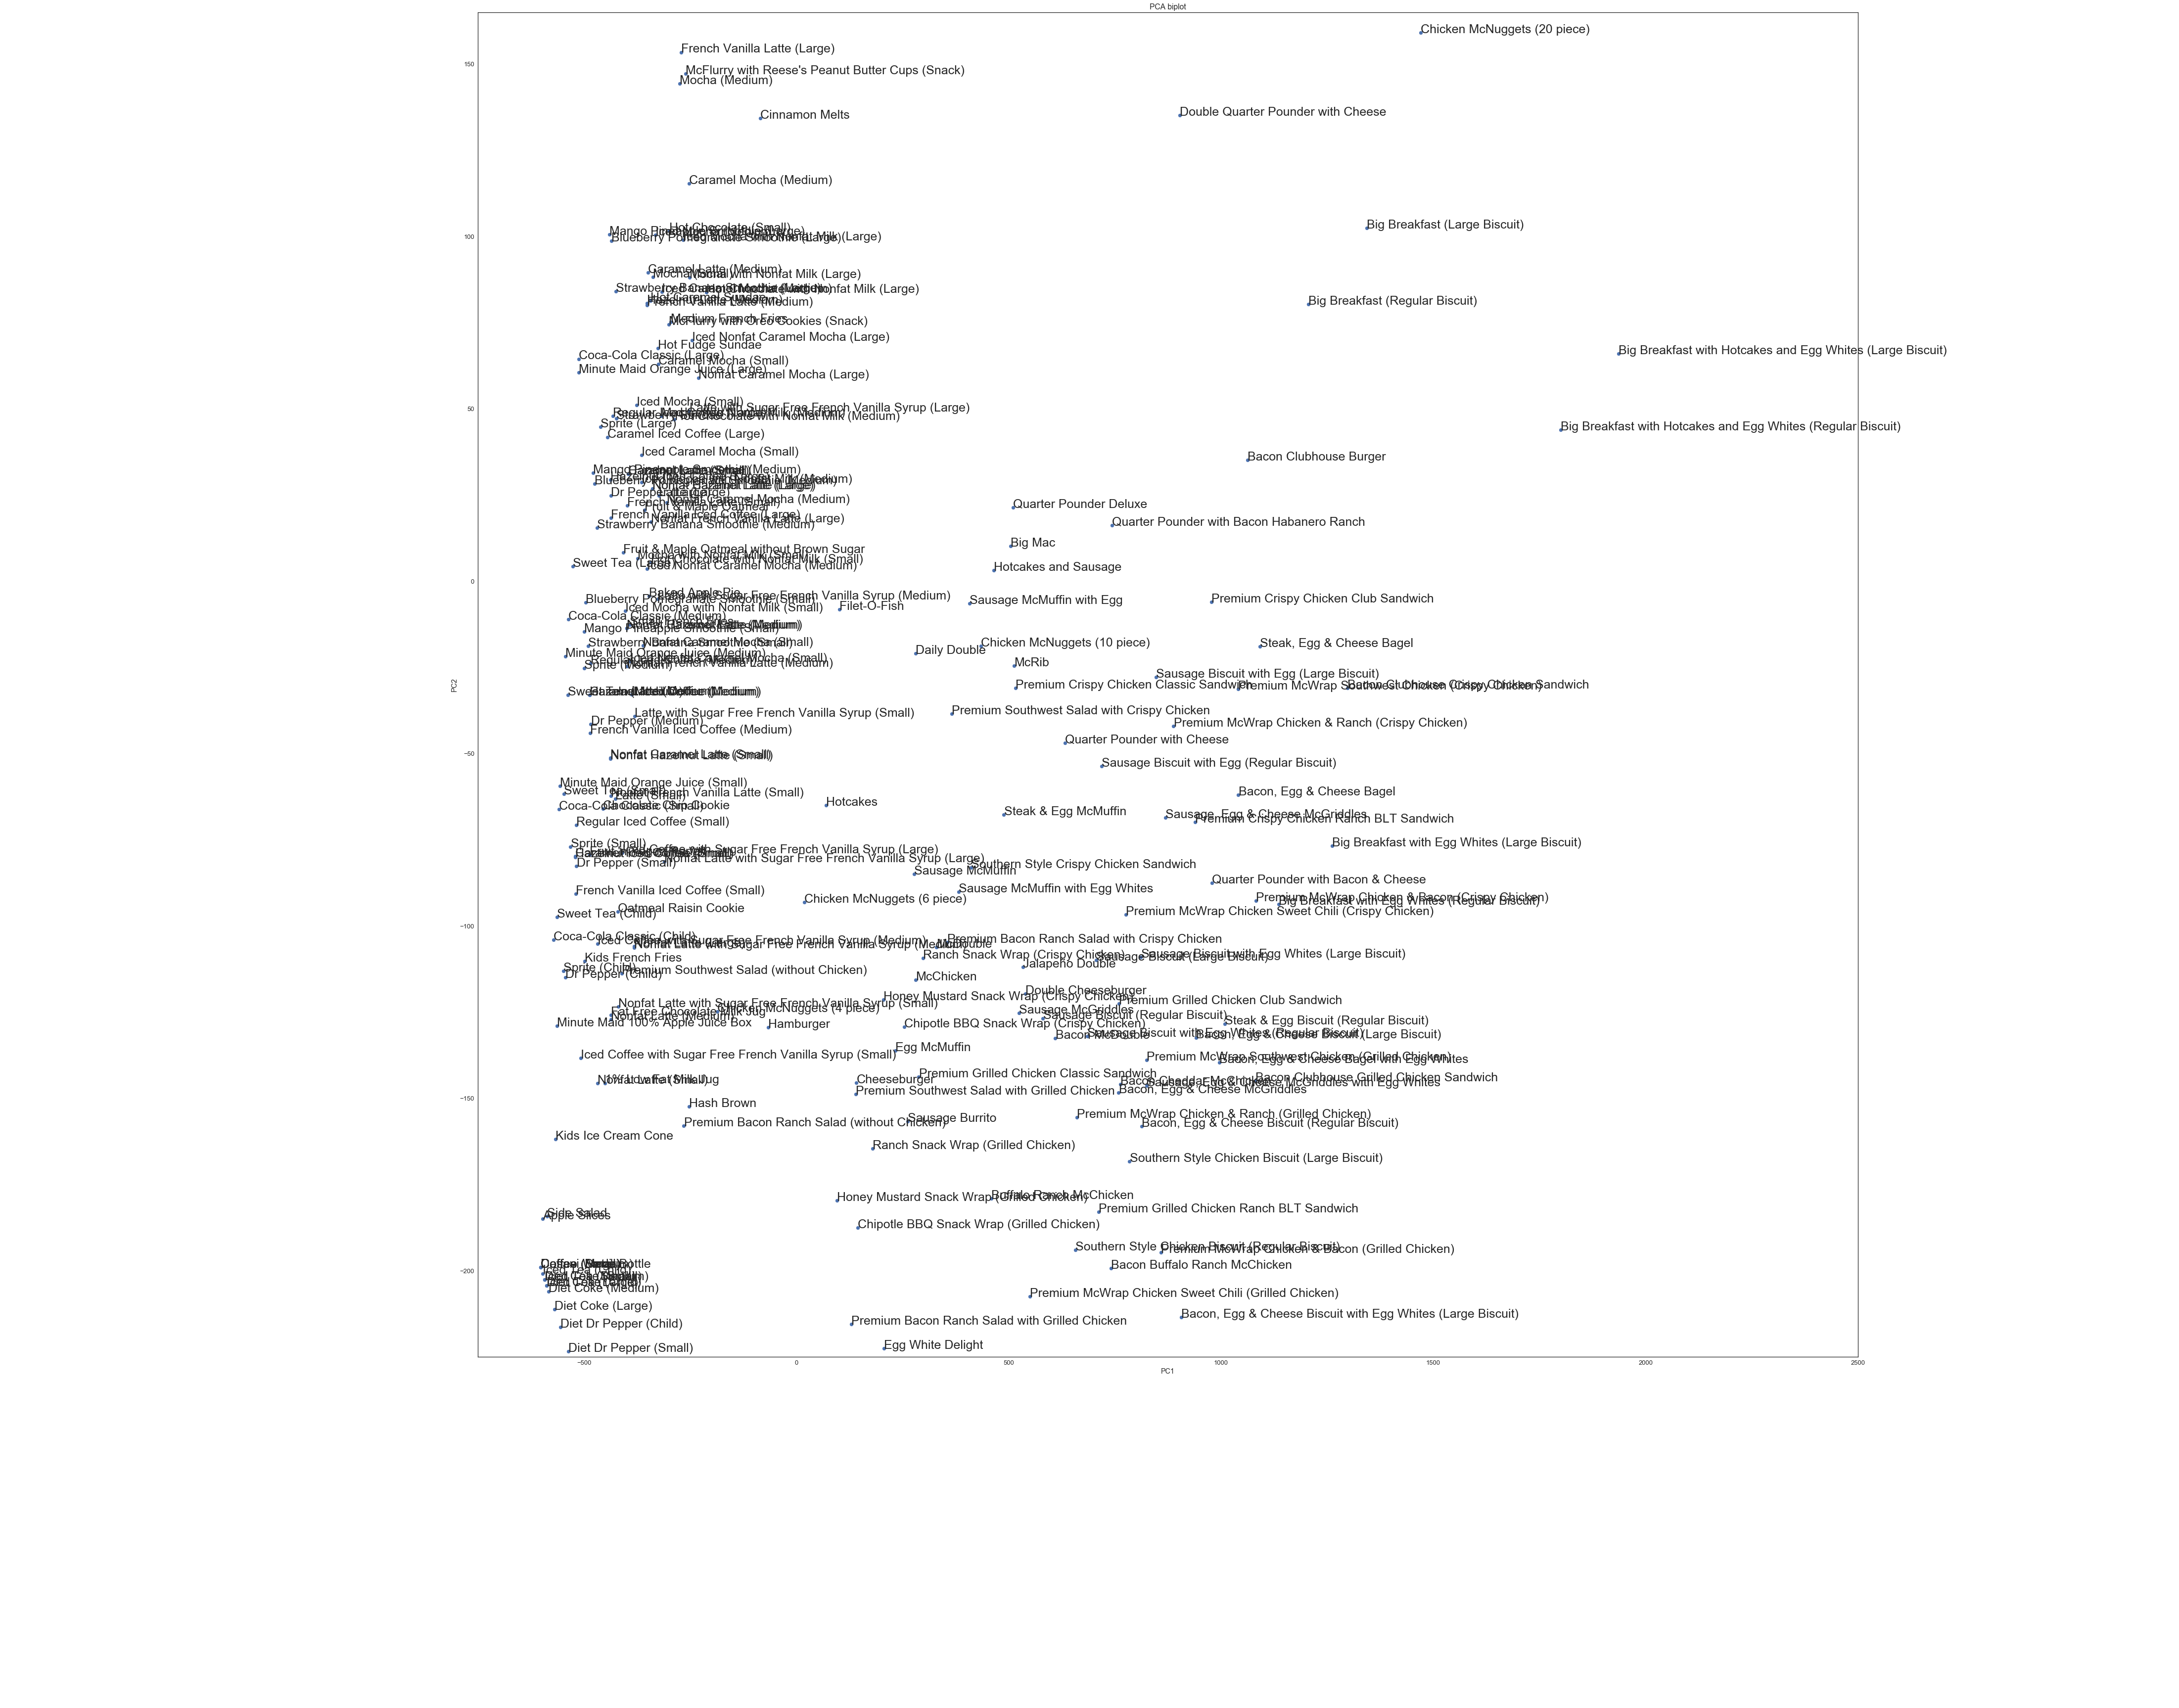

In [46]:
# limit to food categories
pca_model = skd.PCA().fit(mcd_menu[focus_columns[1:]])

plt.figure(figsize=(50,50))

X = pca_model.transform(mcd_menu[focus_columns[1:]])
plt.scatter(X[:,0], X[:,1])
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('PCA biplot')
plt.ylim(-225,165)
plt.xlim(-750,2500)

for i, s in enumerate(mcd_menu.index):
    plt.annotate(s, xy=X[i,:2]+[0.1,-0.1], fontsize=25)

### Subway

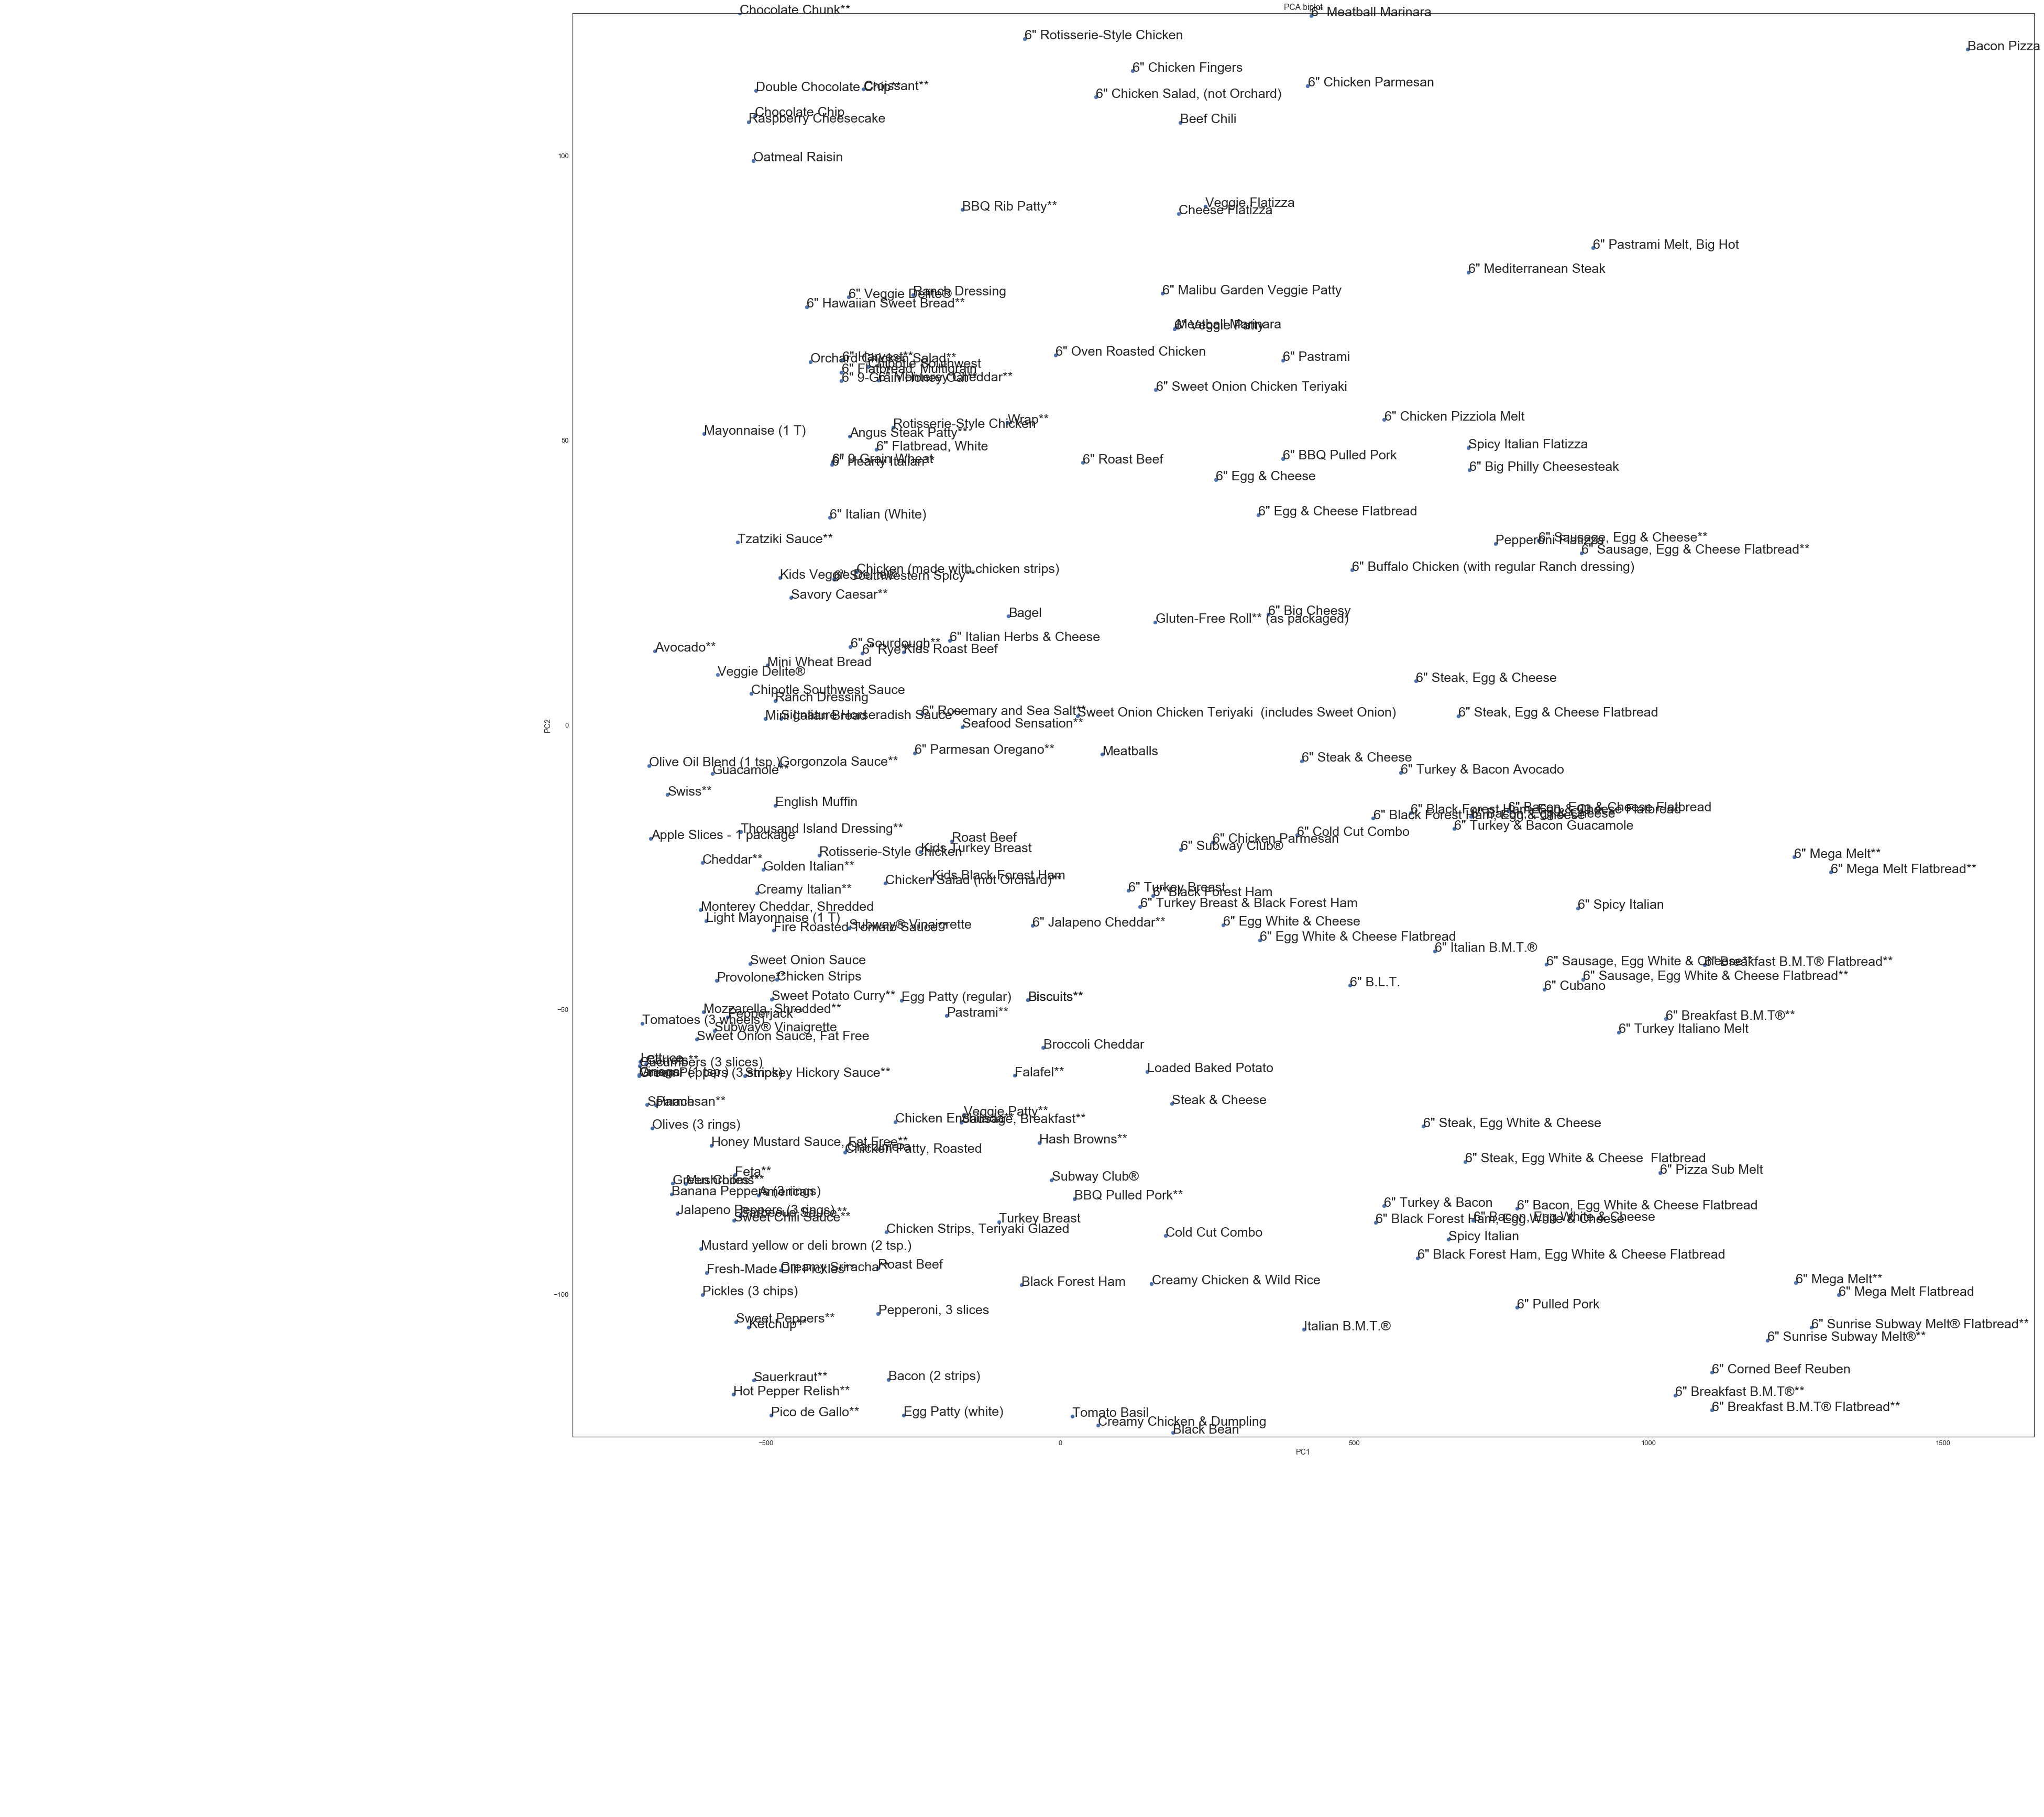

In [47]:
# limit to food categories
pca_model = skd.PCA().fit(subway_menu[focus_columns[1:]])

plt.figure(figsize=(50,50))

X = pca_model.transform(subway_menu[focus_columns[1:]])
plt.scatter(X[:,0], X[:,1])
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('PCA biplot')
plt.ylim(-125,125)
# plt.xlim(-750,1000)

for i, s in enumerate(subway_menu.index):
    plt.annotate(s, xy=X[i,:2]+[0.1,-0.1], fontsize=25)

### Combined

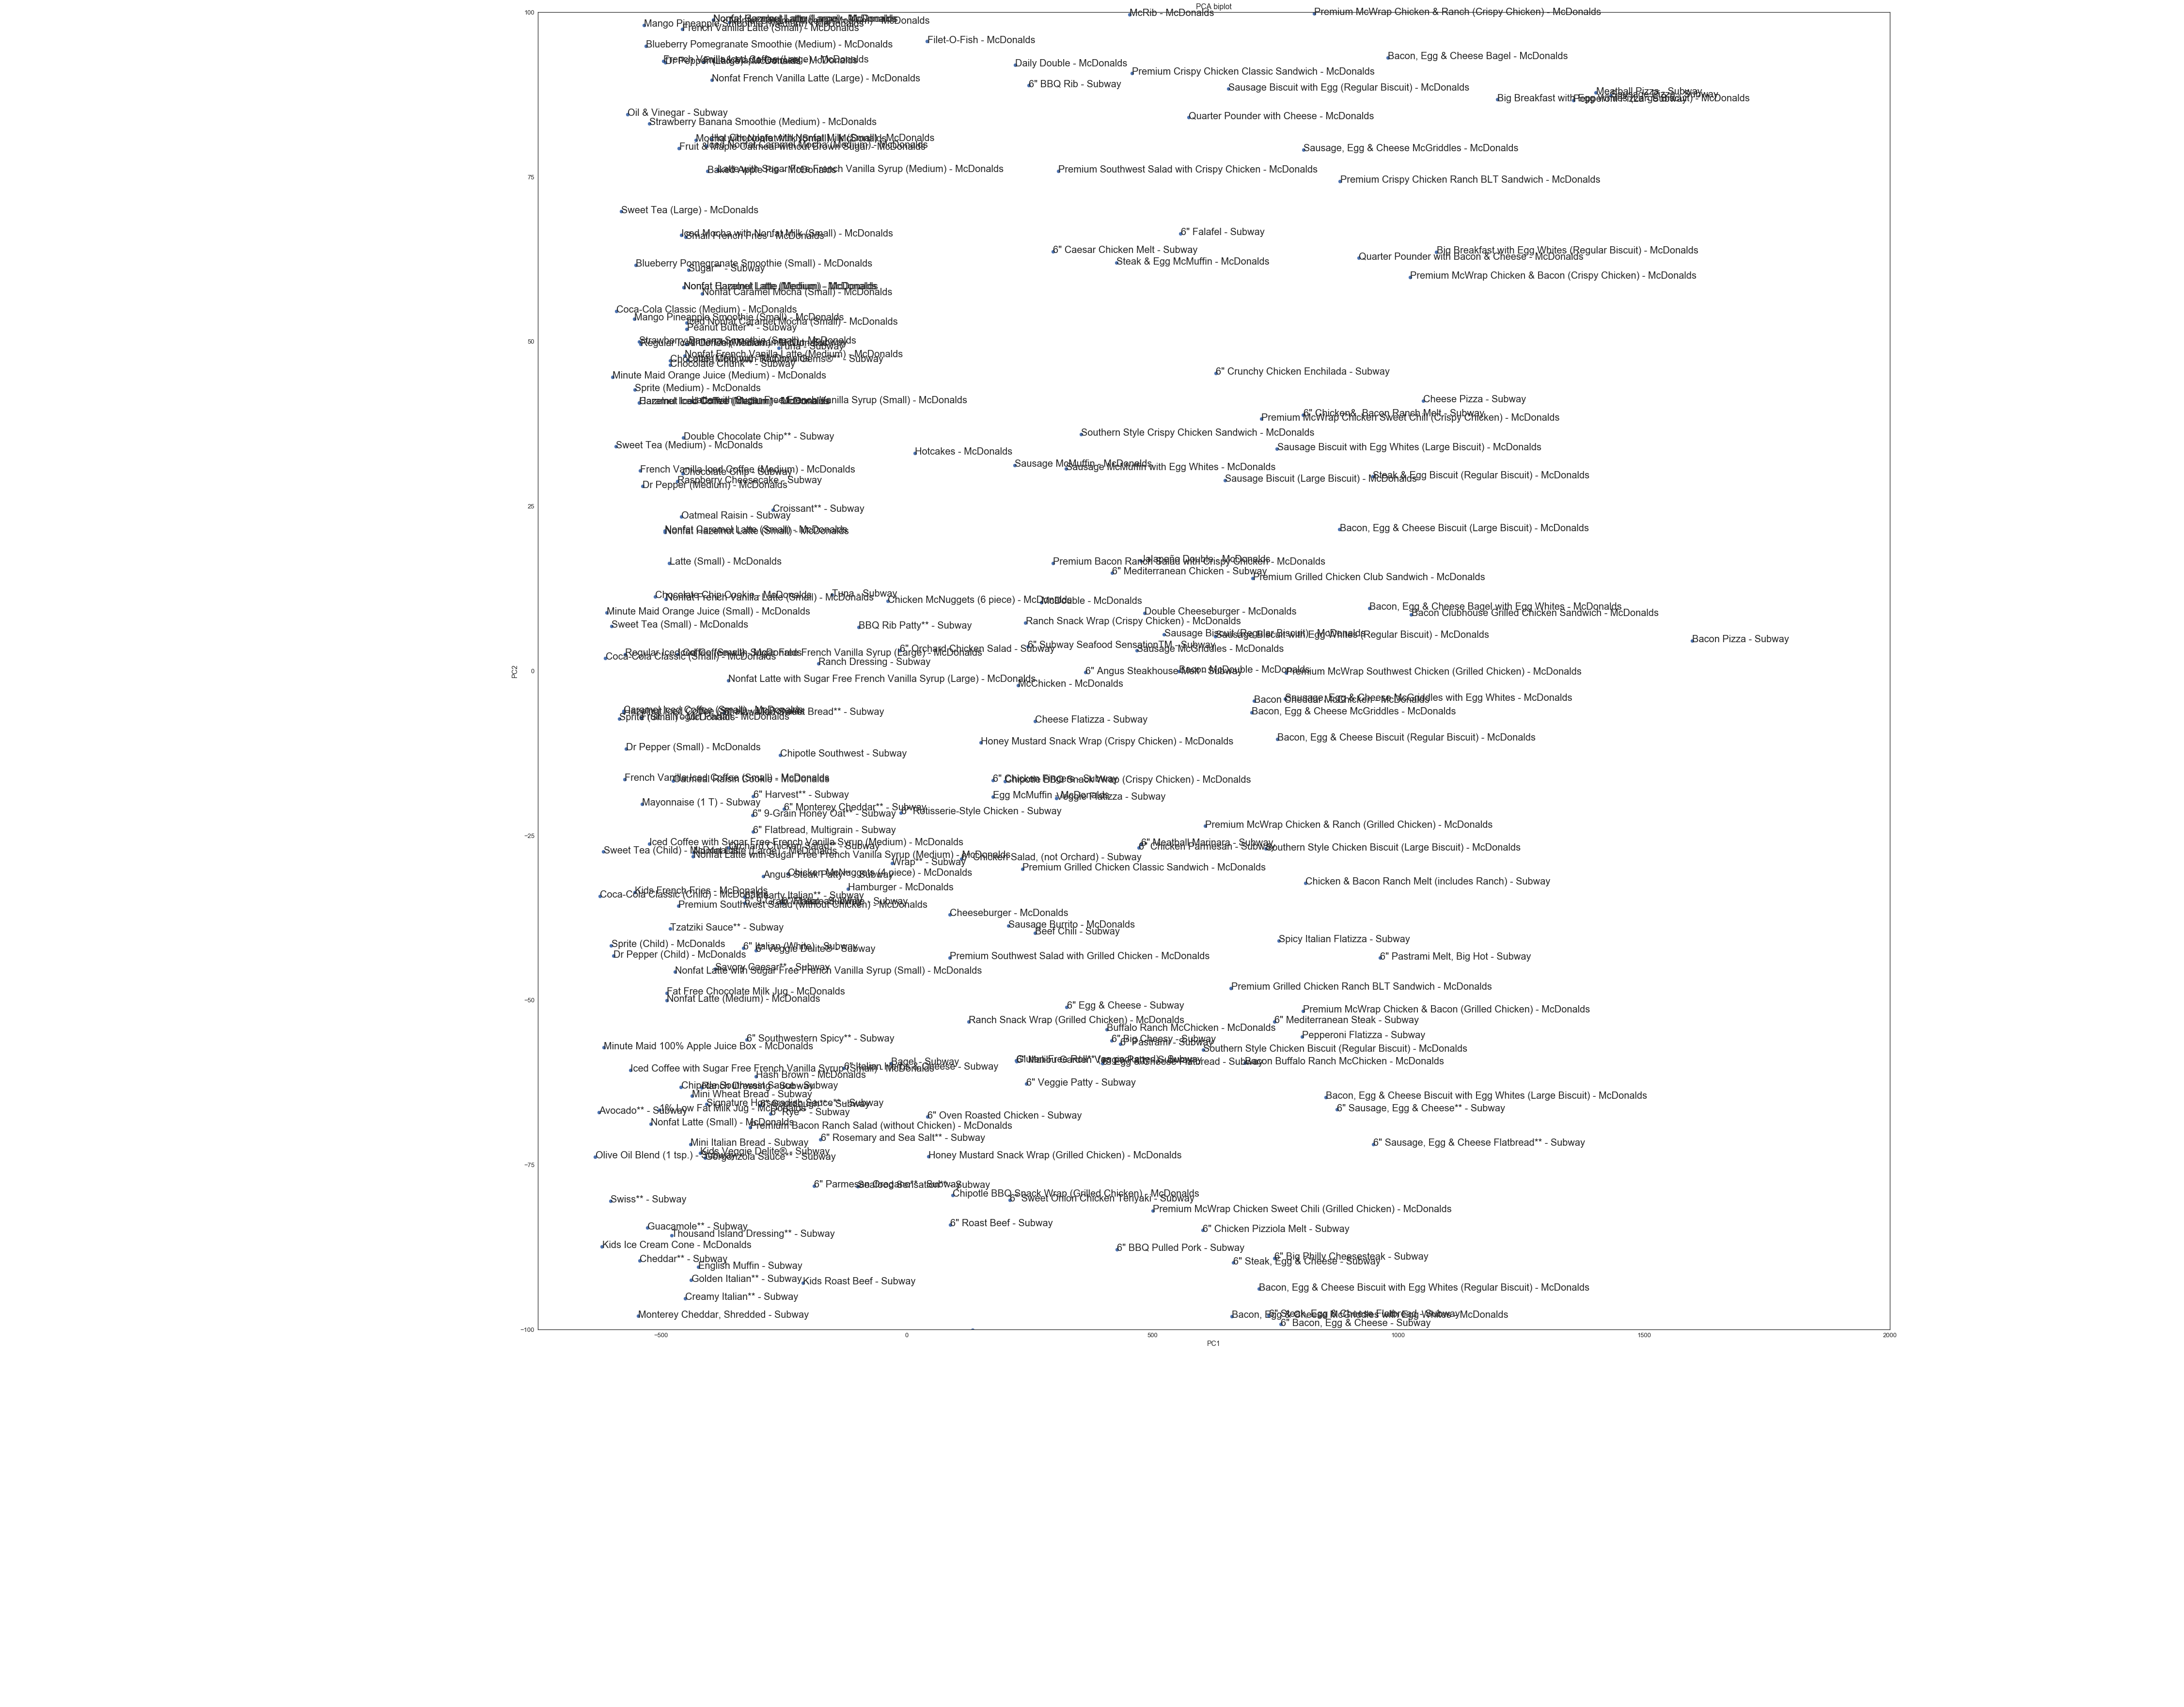

In [48]:
combined_menu['item_restaurant'] = combined_menu.index + " - " + combined_menu.Restaurant
# limit to food categories
pca_model = skd.PCA().fit(combined_menu[focus_columns[1:]])

plt.figure(figsize=(50,50))

X = pca_model.transform(combined_menu[focus_columns[1:]])
plt.scatter(X[:,0], X[:,1])
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('PCA biplot')
plt.ylim(-100,100) # modified the axis range to find area of greatest overlap
plt.xlim(-750,2000) # eliminating white space

for i, s in enumerate(combined_menu.item_restaurant):
    plt.annotate(s, xy=X[i,:2]+[0.2,-0.2], fontsize=20)

### Using evidence from PCA above, investigating similarity of some of the identified items

In [49]:
combo = pd.DataFrame(combined_menu.ix["Cheeseburger"])
combo['Chili'] = combined_menu.ix["Beef Chili"]
combo = combo.T
combo.ix['diff']= combo[focus_columns[2:]].ix[0] - combo[focus_columns[2:]].ix[1]
combo[focus_columns]

Category Serving Size Calories Calories from Fat Total Fat  \
Cheeseburger  Beef & Pork            0      290               100        11   
Chili                Soup          255      360               220        22   
diff                  NaN          NaN      -70              -120       -11   

             Cholesterol Sodium Carbohydrates Sugars Protein  
Cheeseburger          45    680            33      7      15  
Chili                 71    800            20      6      21  
diff                 -26   -120            13      1      -6

In [179]:
combo = pd.DataFrame(combined_menu.ix["6\" Crunchy Chicken Enchilada"])
combo['Premium McWrap Chicken Sweet Chili (Crispy Chicken)'] = combined_menu.ix["Premium McWrap Chicken Sweet Chili (Crispy Chicken)"]
combo = combo.T
combo.ix['diff']= combo[focus_columns[2:]].ix[0] - combo[focus_columns[2:]].ix[1]
combo[focus_columns]

Category  \
6" Crunchy Chicken Enchilada                              Sandwich   
Premium McWrap Chicken Sweet Chili (Crispy Chic...  Chicken & Fish   
diff                                                           NaN   

                                                   Serving Size Calories  \
6" Crunchy Chicken Enchilada                                303      580   
Premium McWrap Chicken Sweet Chili (Crispy Chic...           10      540   
diff                                                        NaN       40   

                                                   Calories from Fat  \
6" Crunchy Chicken Enchilada                                     240   
Premium McWrap Chicken Sweet Chili (Crispy Chic...               200   
diff                                                              40   

                                                   Total Fat Cholesterol  \
6" Crunchy Chicken Enchilada                              26          20   
Premium McWrap Chicken Sweet Chili (Crispy Chic...        23          50   
diff                                                       3         -30   

                                                   Sodium Carbohydrates  \
6" Crunchy Chicken Enchilada                         1120            60   
Premium McWrap Chicken Sweet Chili (Crispy Chic...   1260            61   
diff                                                 -140            -1   

                                                   Sugars Protein  
6" Crunchy Chicken Enchilada                           10      26  
Premium McWrap Chicken Sweet Chili (Crispy Chic...     14      23  
diff                                                   -4       3

In [184]:
combo = pd.DataFrame(combined_menu.ix["McChicken"])
combo['6\" Angus Steakhouse Melt'] = combined_menu.ix["6\" Angus Steakhouse Melt"]
combo = combo.T
combo.ix['diff']= combo[focus_columns[2:]].ix[0] - combo[focus_columns[2:]].ix[1]
combo[focus_columns]

Category Serving Size Calories  \
McChicken                 Chicken & Fish            5      360   
6" Angus Steakhouse Melt        Sandwich          247      450   
diff                                 NaN          NaN      -90   

                         Calories from Fat Total Fat Cholesterol Sodium  \
McChicken                              140        16          35    800   
6" Angus Steakhouse Melt               180        20          50    890   
diff                                   -40        -4         -15    -90   

                         Carbohydrates Sugars Protein  
McChicken                           40      5      14  
6" Angus Steakhouse Melt            45      7      24  
diff                                -5     -2     -10

In [183]:
combo = pd.DataFrame(combined_menu.ix["Bacon, Egg & Cheese Biscuit with Egg Whites (Large Biscuit)"])
combo['6\" Sausage, Egg & Cheese'] = combined_menu.ix["6\" Sausage, Egg & Cheese**"]
combo = combo.T
combo.ix['diff']= combo[focus_columns[2:]].ix[0] - combo[focus_columns[2:]].ix[1]
combo[focus_columns]

Category Serving Size  \
Bacon, Egg & Cheese Biscuit with Egg Whites (La...  Breakfast            5   
6" Sausage, Egg & Cheese                            Breakfast          231   
diff                                                      NaN          NaN   

                                                   Calories Calories from Fat  \
Bacon, Egg & Cheese Biscuit with Egg Whites (La...      470               220   
6" Sausage, Egg & Cheese                                510               210   
diff                                                    -40                10   

                                                   Total Fat Cholesterol  \
Bacon, Egg & Cheese Biscuit with Egg Whites (La...        25          35   
6" Sausage, Egg & Cheese                                  24         205   
diff                                                       1        -170   

                                                   Sodium Carbohydrates  \
Bacon, Egg & Cheese Biscuit with Egg Whites (La...   1420            42   
6" Sausage, Egg & Cheese                             1400            45   
diff                                                   20            -3   

                                                   Sugars Protein  
Bacon, Egg & Cheese Biscuit with Egg Whites (La...      4      20  
6" Sausage, Egg & Cheese                                6      29  
diff                                                   -2      -9

* Similarity is most evident in Sugars, Protein, Carbohydrates, and Total Fat columns while there is a large difference in the Calories column
* McDonalds tended to have a higher calorie count, but important to remember that these are all calculations for 6" subs

## Answer Remaining Research Questions